# **Part 1: Exploratory Data Analysis (EDA)**

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from matplotlib.patches import Patch


## **Load and inspect dataset structure**

In [14]:
df = pd.read_csv("../data/raw/coronary_disease.csv")

In [15]:
df.head(10)

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,M,39,4.0,No,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,F,46,2.0,No,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,M,48,1.0,Yes,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,F,61,3.0,Yes,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,F,46,3.0,Yes,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,F,43,2.0,No,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,F,63,1.0,No,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,F,45,2.0,Yes,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,M,52,1.0,No,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,M,43,1.0,Yes,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [4]:
print("Dataset shape:", df.shape)
print("Number of observations:", df.shape[0])

Dataset shape: (4238, 16)
Number of observations: 4238


In [5]:
# Column names
df.columns.tolist()

['sex',
 'age',
 'education',
 'currentSmoker',
 'cigsPerDay',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose',
 'TenYearCHD']

In [6]:
# Rename columns to make them more uniform
df = df.rename(
    columns={
        "education": "education_level",
        "currentSmoker": "current_smoker",
        "cigsPerDay": "cigarettes_per_day",
        "BPMeds": "bp_medication",
        "prevalentStroke": "previous_stroke",
        "prevalentHyp": "hypertension",
        "totChol": "total_cholesterol",
        "sysBP": "systolic_bp",
        "diaBP": "diastolic_bp",
        "BMI": "bmi",
        "heartRate": "heart_rate",
        "TenYearCHD": "ten_year_chd",
    }
)

In [7]:
# Check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 4238 non-null   object 
 1   age                 4238 non-null   int64  
 2   education_level     4133 non-null   float64
 3   current_smoker      4238 non-null   object 
 4   cigarettes_per_day  4209 non-null   float64
 5   bp_medication       4185 non-null   float64
 6   previous_stroke     4238 non-null   int64  
 7   hypertension        4238 non-null   int64  
 8   diabetes            4238 non-null   int64  
 9   total_cholesterol   4188 non-null   float64
 10  systolic_bp         4238 non-null   float64
 11  diastolic_bp        4238 non-null   float64
 12  bmi                 4219 non-null   float64
 13  heart_rate          4237 non-null   float64
 14  glucose             3850 non-null   float64
 15  ten_year_chd        4238 non-null   int64  
dtypes: flo

In [8]:
# Change variable types
df["education_level"] = df["education_level"].astype("Int64")

# Binary categorical variables
df["sex"] = df["sex"].map({"M": 1, "F": 0}).astype("int")
df["current_smoker"] = df["current_smoker"].map({"Yes": 1, "No": 0}).astype("int")
df["bp_medication"] = df["bp_medication"].astype("Int64")
df["previous_stroke"] = df["previous_stroke"].astype("int")
df["hypertension"] = df["hypertension"].astype("int")
df["diabetes"] = df["diabetes"].astype("int")

## **Analyze missing values**

In [9]:
# Calculate missing values
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame(
    {"Missing Values": missing_count, "Percentage": missing_percent}
)

missing_df = missing_df.sort_values(by="Missing Values", ascending=False)

missing_df

,Missing Values,Percentage
glucose,388,9.155262
education_level,105,2.477584
bp_medication,53,1.250590
total_cholesterol,50,1.179802
cigarettes_per_day,29,0.684285
bmi,19,0.448325
heart_rate,1,0.023596
sex,0,0.000000
age,0,0.000000
current_smoker,0,0.000000


To address missing values, we will apply simple imputation for variables with less than 5% missing data. For numerical variables, missing values will be replaced with the median, while for categorical variables, the mode will be used.

In [10]:
# Separate numeric and binary categorical columns
numerical_cols = [
    col for col in df.select_dtypes(include="number").columns if df[col].nunique() > 4
]

categorical_cols = [
    col for col in df.select_dtypes(include="number").columns if df[col].nunique() <= 4
]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'cigarettes_per_day', 'total_cholesterol', 'systolic_bp', 'diastolic_bp', 'bmi', 'heart_rate', 'glucose']
Categorical columns: ['sex', 'education_level', 'current_smoker', 'bp_medication', 'previous_stroke', 'hypertension', 'diabetes', 'ten_year_chd']


In [11]:
# Filter columns with <5% missing
numerical_cols_to_impute = [
    col for col in numerical_cols if df[col].isnull().mean() < 0.05
]
categorical_cols_to_impute = [
    col for col in categorical_cols if df[col].isnull().mean() < 0.05
]

# Impute numerical columns with median
for col in numerical_cols_to_impute:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Impute categorical columns with mode
for col in categorical_cols_to_impute:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

For glucose, which has over 5% missing values (9.16%), we will use KNN imputation because glucose is clinically important and is correlated with BMI, blood pressure, and cholesterol, making this method suitable for estimating the missing values.

In [12]:
# Columns to use as predictors
predictors = [
    "glucose",
    "age",
    "bmi",
    "systolic_bp",
    "diastolic_bp",
    "total_cholesterol",
    "heart_rate",
    "cigarettes_per_day",
]

knn_imputer = KNNImputer(n_neighbors=5)

imputed_values = knn_imputer.fit_transform(df[predictors])

df["glucose"] = imputed_values[:, 0]

## **Analyze Outliers**

In [13]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
sex,4238.0,0.429212,0.495022,0.0,0.0,0.0,1.0,1.0
age,4238.0,49.584946,8.57216,32.0,42.0,49.0,56.0,70.0
education_level,4238.0,1.954696,1.01851,1.0,1.0,2.0,3.0,4.0
current_smoker,4238.0,0.494101,0.500024,0.0,0.0,0.0,1.0,1.0
cigarettes_per_day,4238.0,8.941482,11.902399,0.0,0.0,0.0,20.0,70.0
bp_medication,4238.0,0.029259,0.168552,0.0,0.0,0.0,0.0,1.0
previous_stroke,4238.0,0.005899,0.076587,0.0,0.0,0.0,0.0,1.0
hypertension,4238.0,0.310524,0.462763,0.0,0.0,0.0,1.0,1.0
diabetes,4238.0,0.02572,0.158316,0.0,0.0,0.0,0.0,1.0
total_cholesterol,4238.0,236.689476,44.327427,107.0,206.0,234.0,262.0,696.0


In [14]:
# Detect outliers using IQR method
def outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers


outlier_iqr_summary = {}

for col in numerical_cols:
    outliers = outliers_iqr(df[col])
    outlier_iqr_summary[col] = {
        "Count": len(outliers),
        "Percentage": len(outliers) / len(df) * 100,
    }

outlier_iqr_summary_df = pd.DataFrame(outlier_iqr_summary).T.sort_values(
    by="Count", ascending=False
)
outlier_iqr_summary_df

,Count,Percentage
glucose,232.0,5.474280
systolic_bp,126.0,2.973101
bmi,97.0,2.288815
diastolic_bp,81.0,1.911279
heart_rate,76.0,1.793299
total_cholesterol,57.0,1.344974
cigarettes_per_day,12.0,0.283152
age,0.0,0.000000


In [15]:
# Detect outliers using Z-score (>3)
outlier_zscore_summary = {}

for col in numerical_cols:
    z_score = np.abs(stats.zscore(df[col]))
    num_outliers_zscore = np.sum(z_score > 3)
    percent_outliers_zscore = num_outliers_zscore / len(df) * 100
    outlier_zscore_summary[col] = {
        "Count": num_outliers_zscore,
        "Percentage": percent_outliers_zscore,
    }

outlier_zscore_summary_df = pd.DataFrame(outlier_zscore_summary).T.sort_values(
    by="Count", ascending=False
)
outlier_zscore_summary_df

,Count,Percentage
bmi,60.0,1.415762
glucose,50.0,1.179802
systolic_bp,48.0,1.132610
diastolic_bp,41.0,0.967437
total_cholesterol,25.0,0.589901
heart_rate,23.0,0.542709
cigarettes_per_day,21.0,0.495517
age,0.0,0.000000


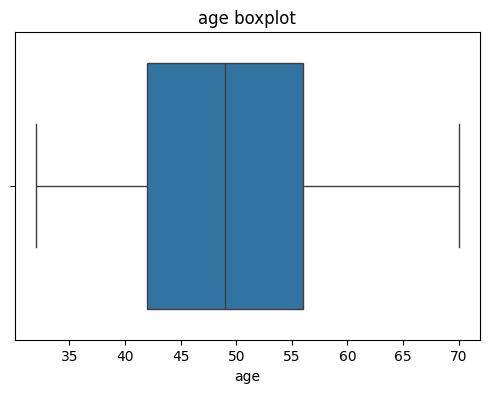

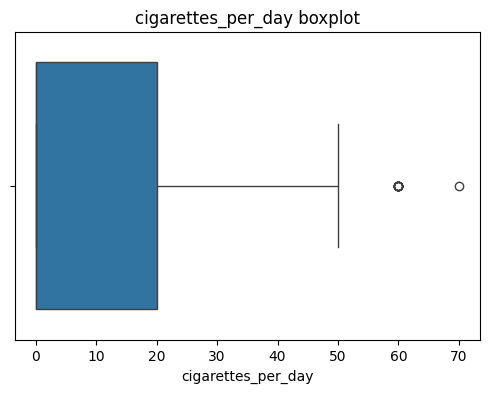

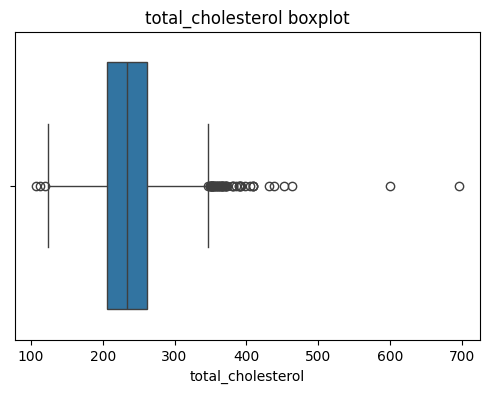

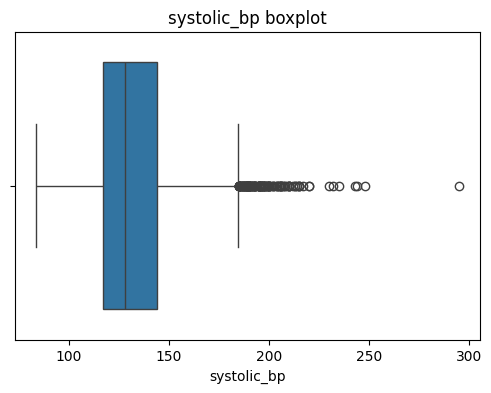

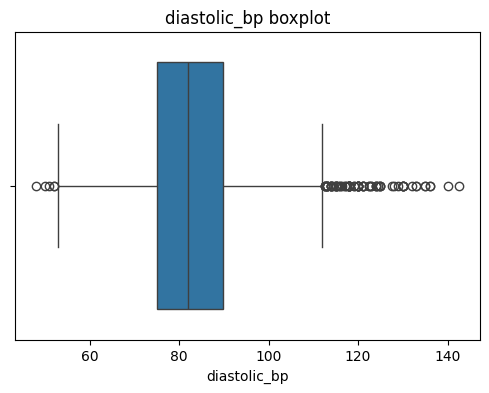

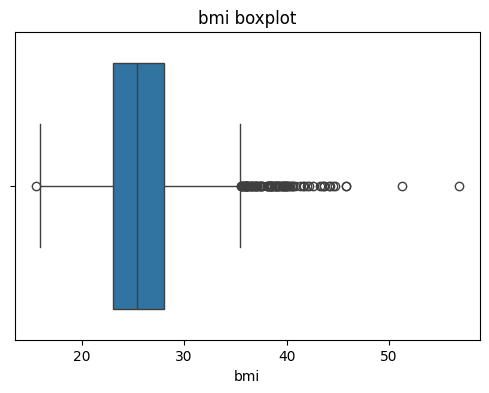

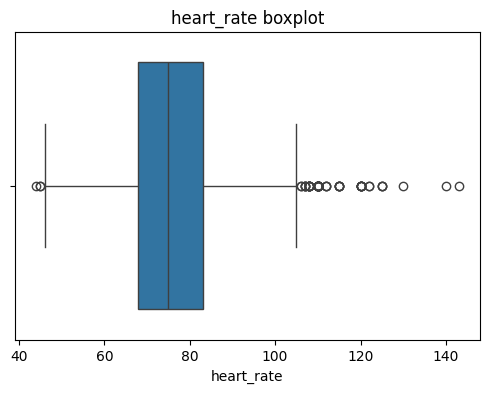

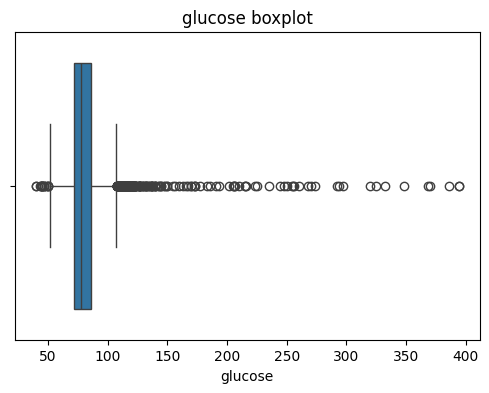

In [16]:
# Outliers visualization
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(col + " boxplot")
    plt.show()

Outliers were identified using both IQR and Z-score methods. We can see that the IQR method finds more outliers than Z-score this is because Z-score (>3) only flags extreme values.

Since these extreme values may correspond to clinically relevant cases, outliers were retained.

In [1]:
# Save cleaned df
df.to_csv("../data/processed/cleaned_coronary_data.csv", index=False)

NameError: name 'df' is not defined

In [ ]:
df = pd.read_csv("../data/processed/cleaned_coronary_data.csv", sep = ',' ,encoding="utf-8")

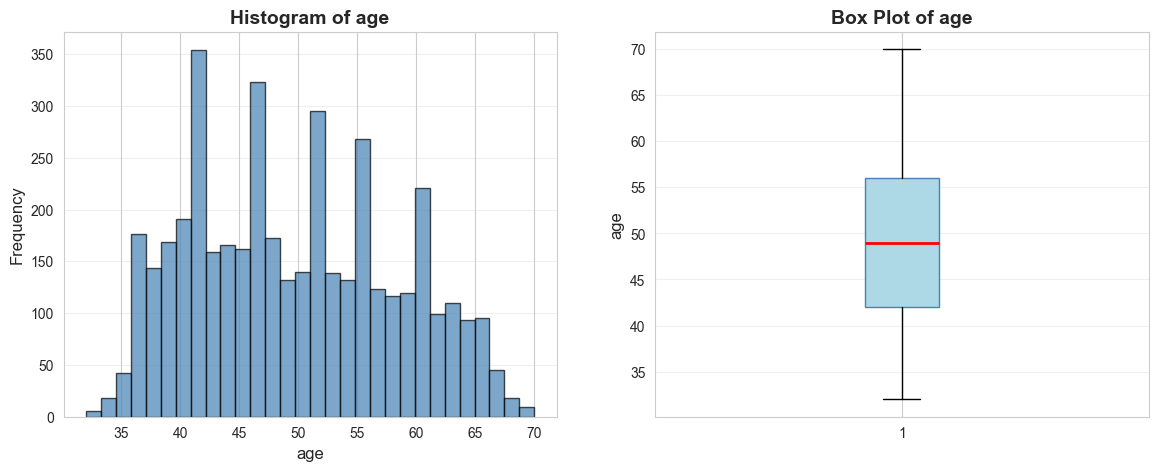

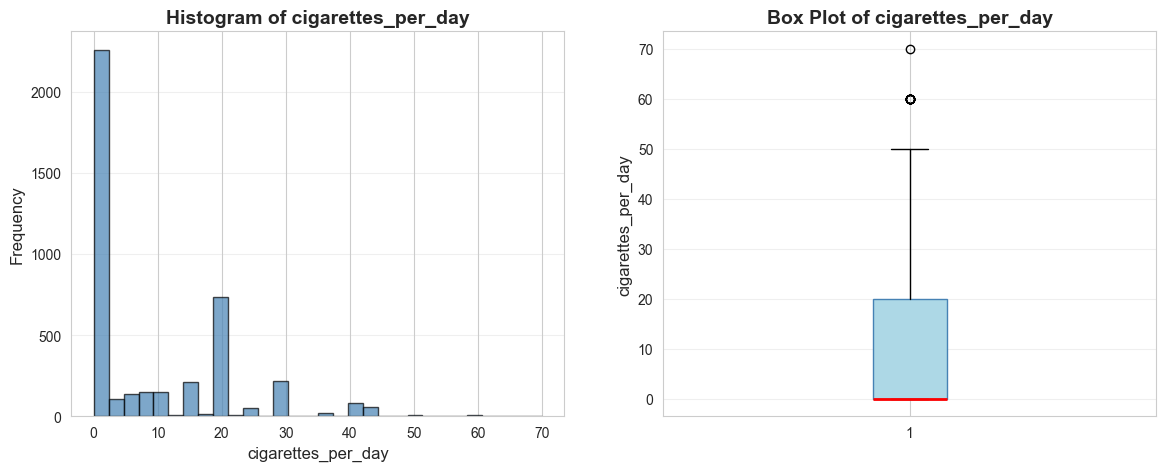

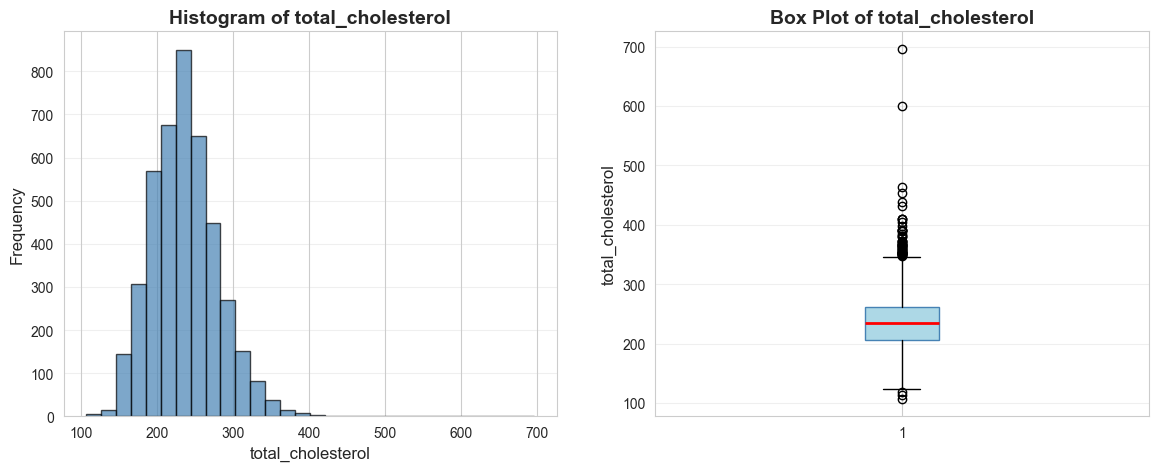

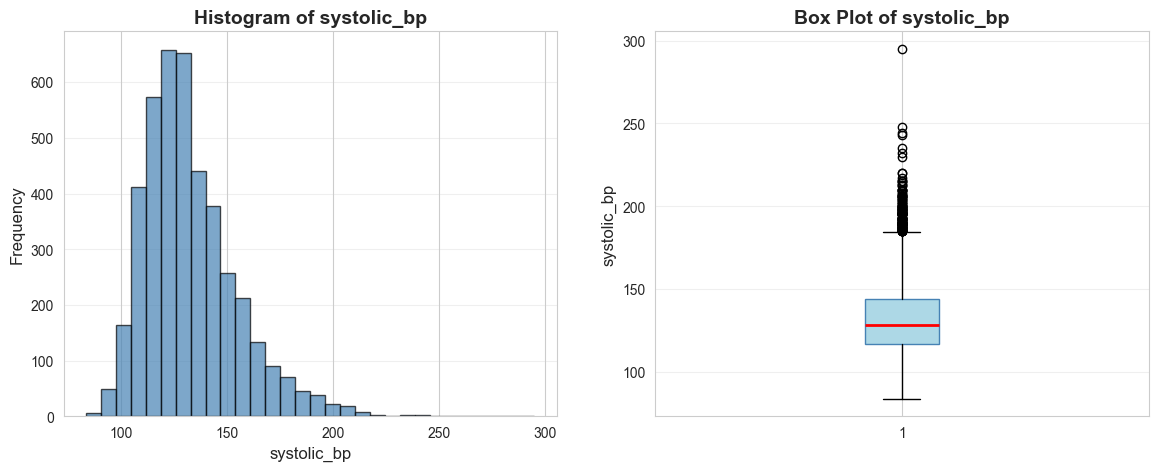

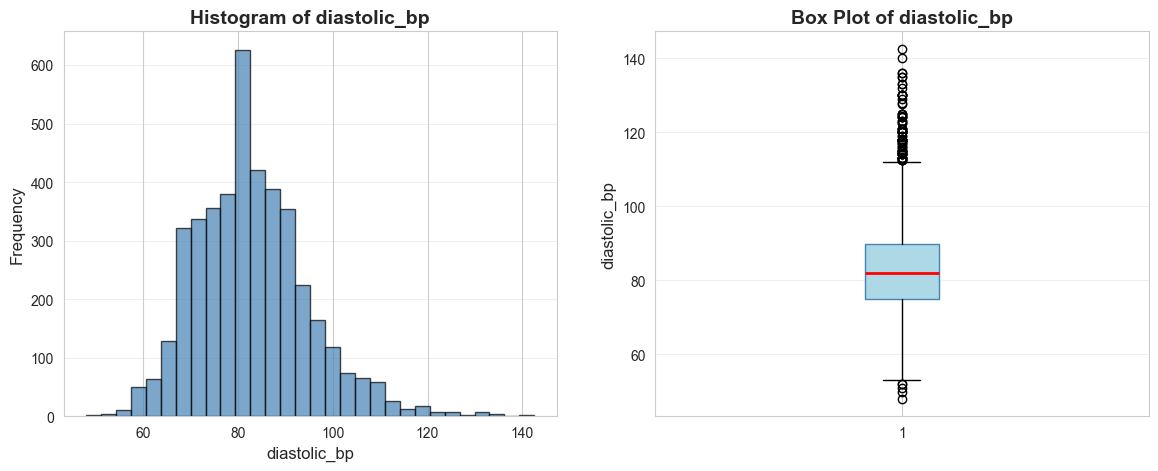

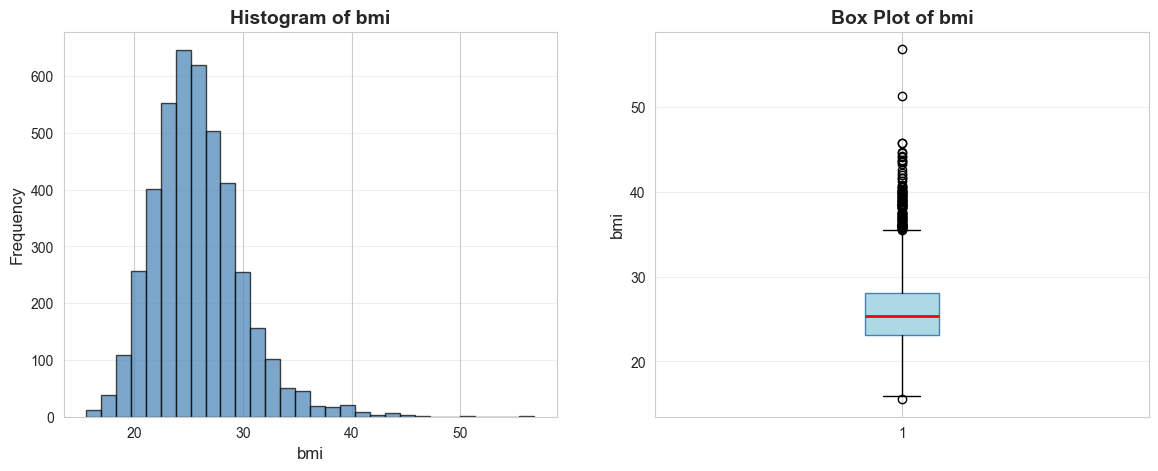

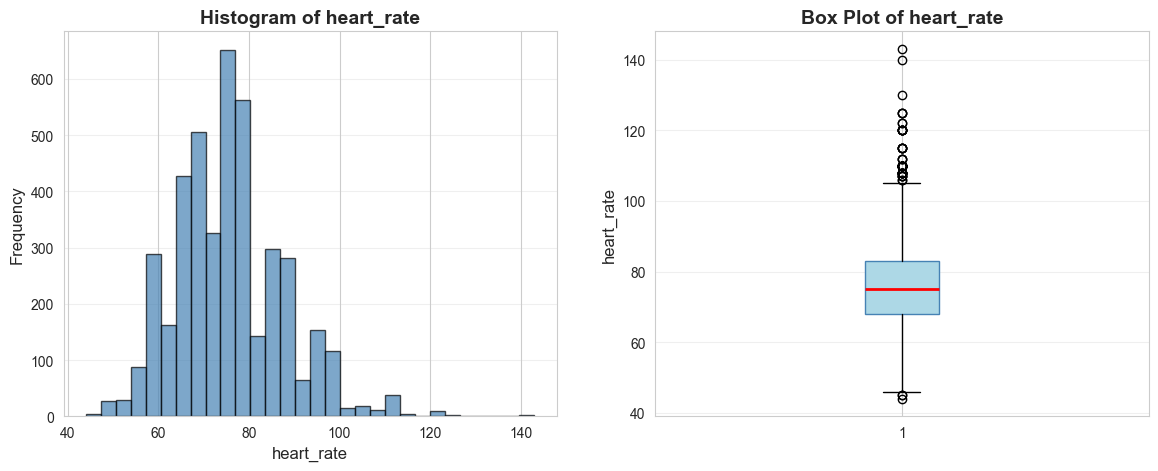

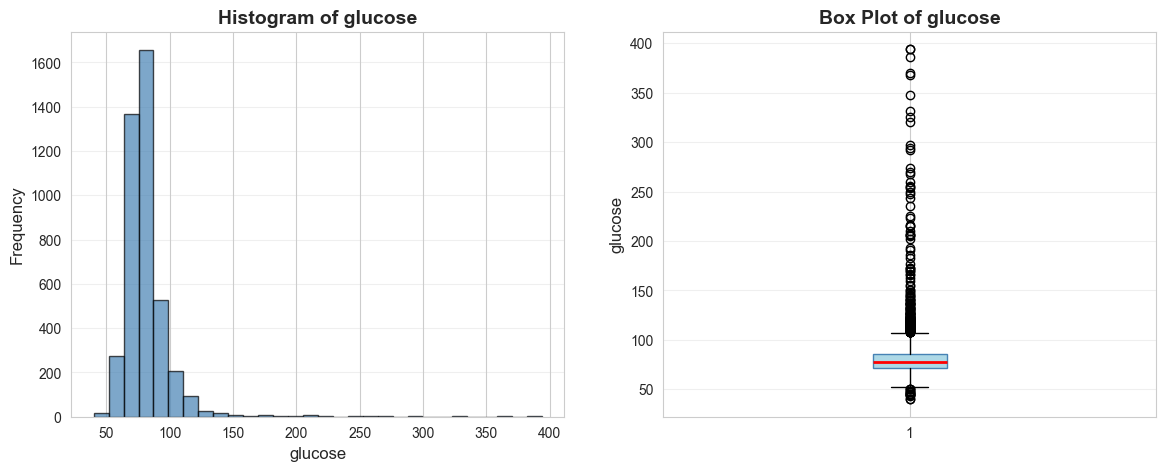

In [ ]:

# From the task performed by the previous collaborator we can infer which of the variables are categorical and which are numerical
continuous_cols = ['age', 'cigarettes_per_day', 'total_cholesterol',
                   'systolic_bp', 'diastolic_bp', 'bmi', 'heart_rate', 'glucose']

categorical_cols = ['sex', 'education_level','current_smoker', 'bp_medication', 'previous_stroke',
                    'hypertension', 'diabetes', 'ten_year_chd']

sns.set_style("whitegrid")

#Plotting continuous variables

for col in continuous_cols:
    if col in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Histogram
        axes[0].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel("Frequency", fontsize=12)
        axes[0].set_title(f"Histogram of {col}", fontsize=14, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)

        axes[1].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='steelblue'),
                       medianprops=dict(color='red', linewidth=2))
        axes[1].set_ylabel(col, fontsize=12)
        axes[1].set_title(f"Box Plot of {col}", fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)


In [17]:
df.head(10)

,sex,age,education_level,current_smoker,cigarettes_per_day,bp_medication,previous_stroke,hypertension,diabetes,total_cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
0,1,39,4,0,0.0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2,0,0.0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,1,20.0,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3,1,30.0,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3,1,23.0,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2,0,0.0,0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1,0,0.0,0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2,1,20.0,0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1,0,0.0,0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1,1,30.0,0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


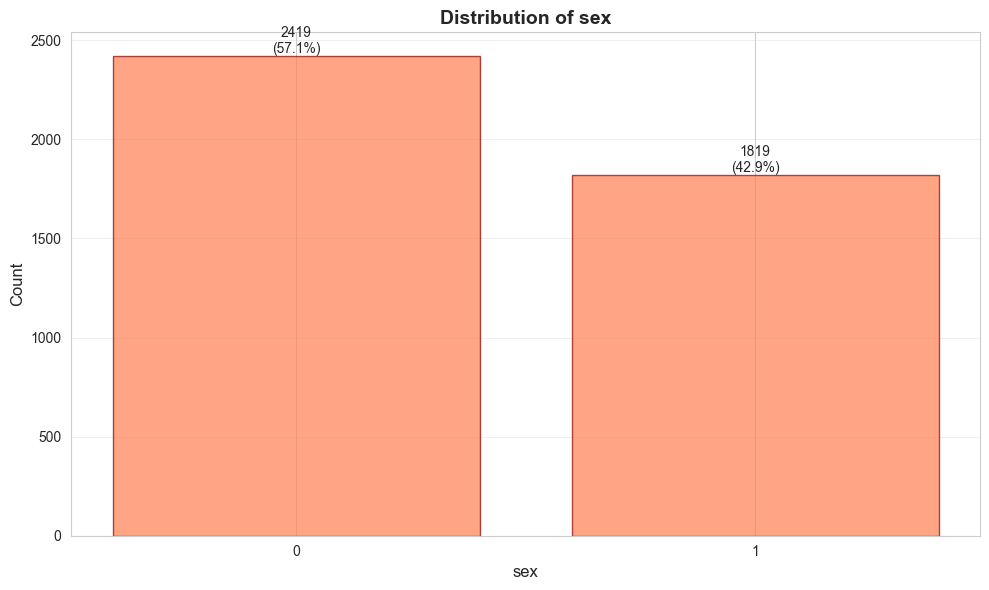

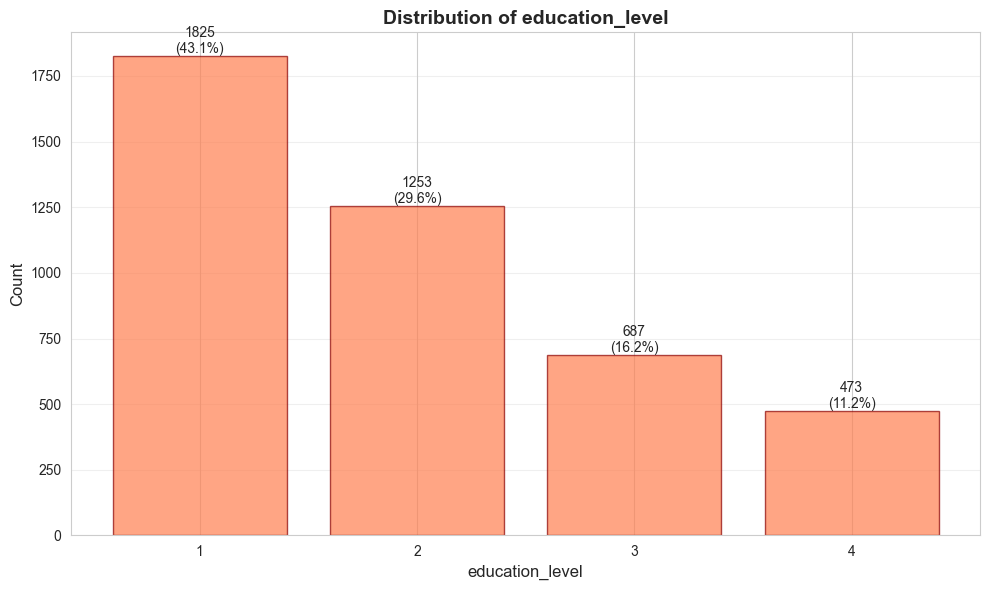

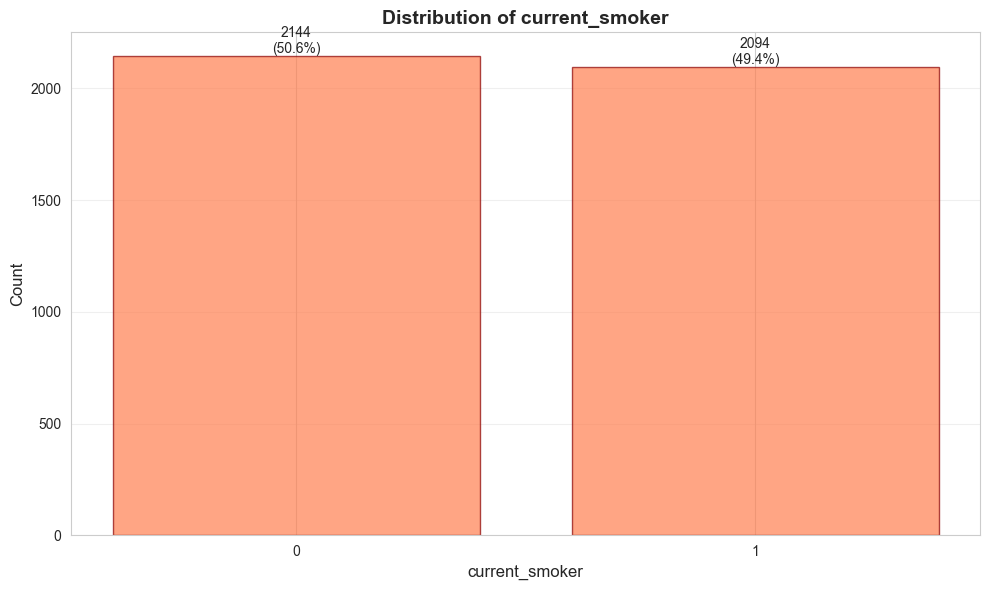

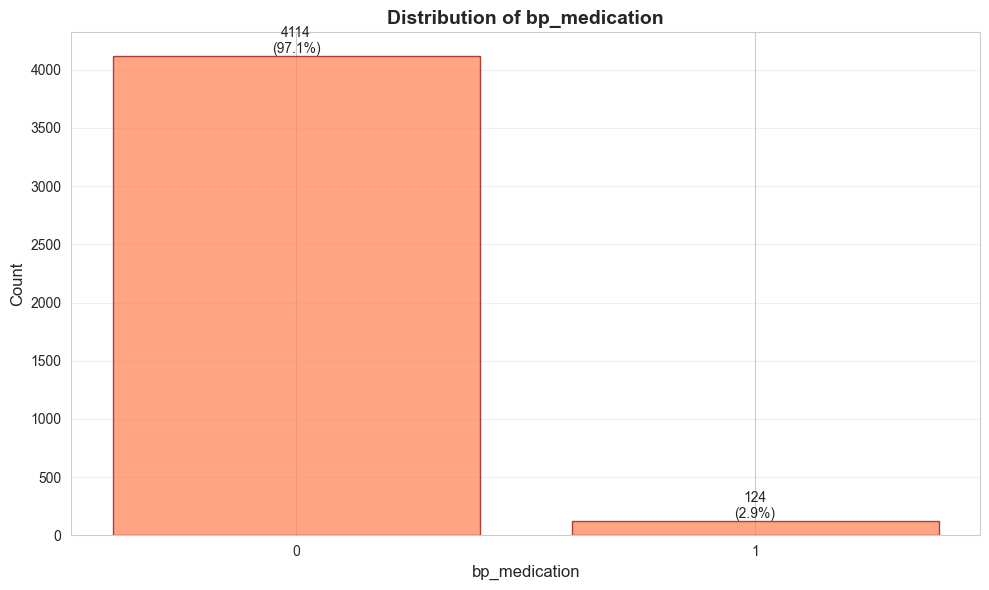

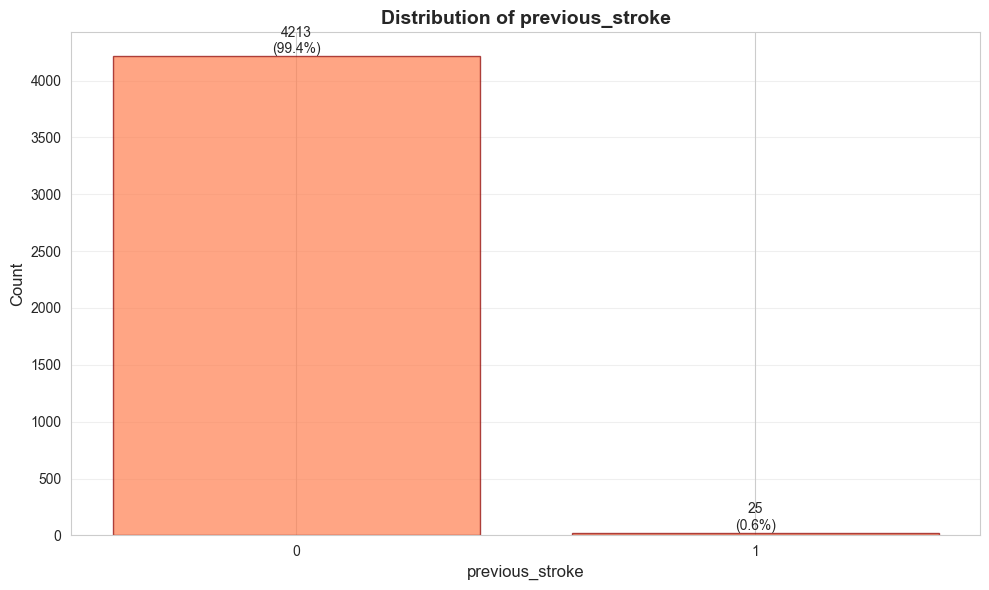

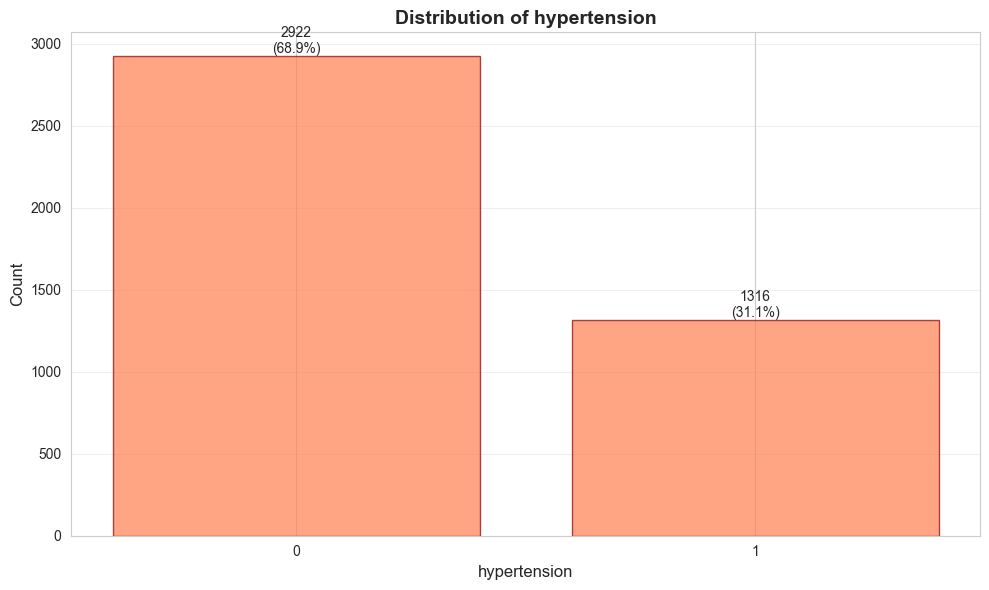

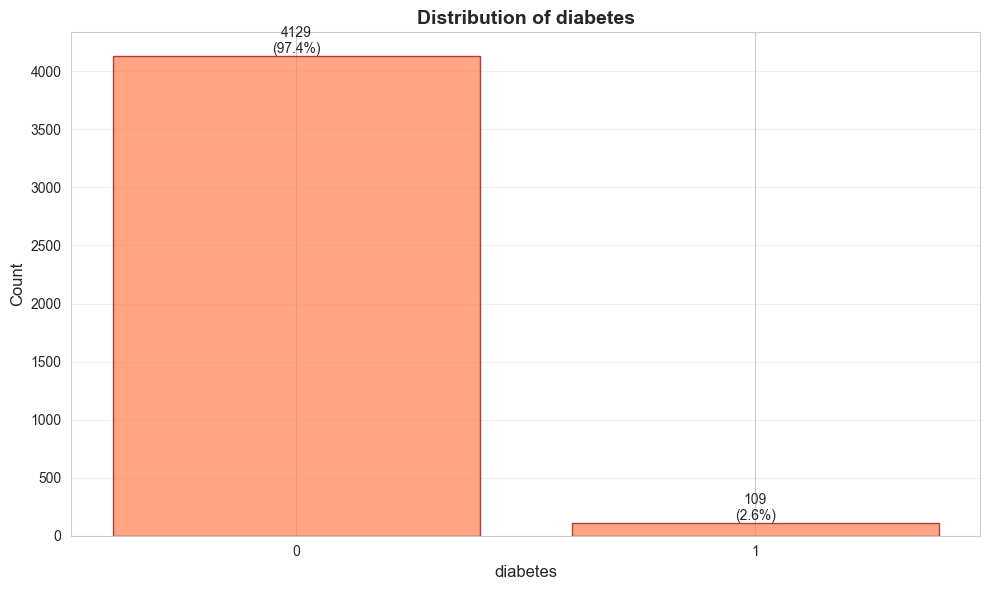

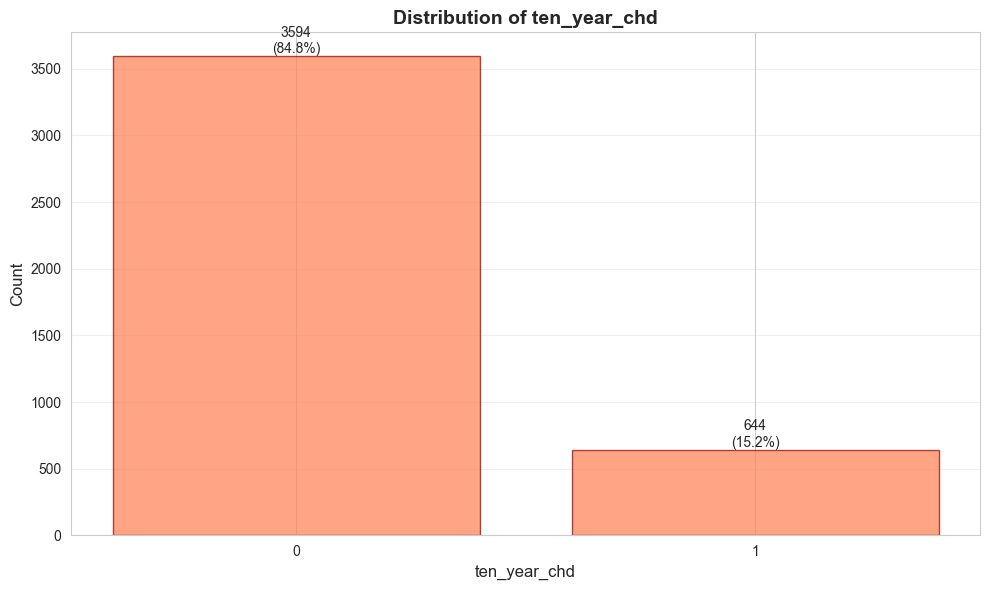

In [19]:
#Categorical variables representation (with barplots)
for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts().sort_index()

        plt.figure(figsize=(10, 6))

        bars = plt.bar(value_counts.index.astype(str), value_counts.values,
                      color='coral', edgecolor='darkred', alpha=0.7)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, #Reminder that Females are mapped as 0 and Males are mapped as 1
                    f'{int(height)}\n({height/len(df)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=10)

        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.title(f"Distribution of {col}", fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()








In [20]:
#Summary table for continuous variables
stats_continuous = pd.DataFrame({
    'Variable': continuous_cols,
    'Count': [df[col].count() for col in continuous_cols],
    'Missing': [df[col].isna().sum() for col in continuous_cols],
    'Missing %': [df[col].isna().sum() / len(df) * 100 for col in continuous_cols],
    'Mean': [df[col].mean() for col in continuous_cols],
    'Std': [df[col].std() for col in continuous_cols],
    'Min': [df[col].min() for col in continuous_cols],
    '25%': [df[col].quantile(0.25) for col in continuous_cols],
    'Median': [df[col].median() for col in continuous_cols],
    '75%': [df[col].quantile(0.75) for col in continuous_cols],
    'Max': [df[col].max() for col in continuous_cols]
})

stats_continuous

,Variable,Count,Missing,Missing %,Mean,Std,Min,25%,Median,75%,Max
0,age,4238,0,0.0,49.584946,8.572160,32.00,42.00,49.0,56.0000,70.0
1,cigarettes_per_day,4238,0,0.0,8.941482,11.902399,0.00,0.00,0.0,20.0000,70.0
2,total_cholesterol,4238,0,0.0,236.689476,44.327427,107.00,206.00,234.0,262.0000,696.0
3,systolic_bp,4238,0,0.0,132.352407,22.038097,83.50,117.00,128.0,144.0000,295.0
4,diastolic_bp,4238,0,0.0,82.893464,11.910850,48.00,75.00,82.0,89.8750,142.5
5,bmi,4238,0,0.0,25.800205,4.071041,15.54,23.08,25.4,28.0375,56.8
6,heart_rate,4238,0,0.0,75.878716,12.025185,44.00,68.00,75.0,83.0000,143.0
7,glucose,4238,0,0.0,81.894384,23.008455,40.00,72.00,78.0,86.0000,394.0


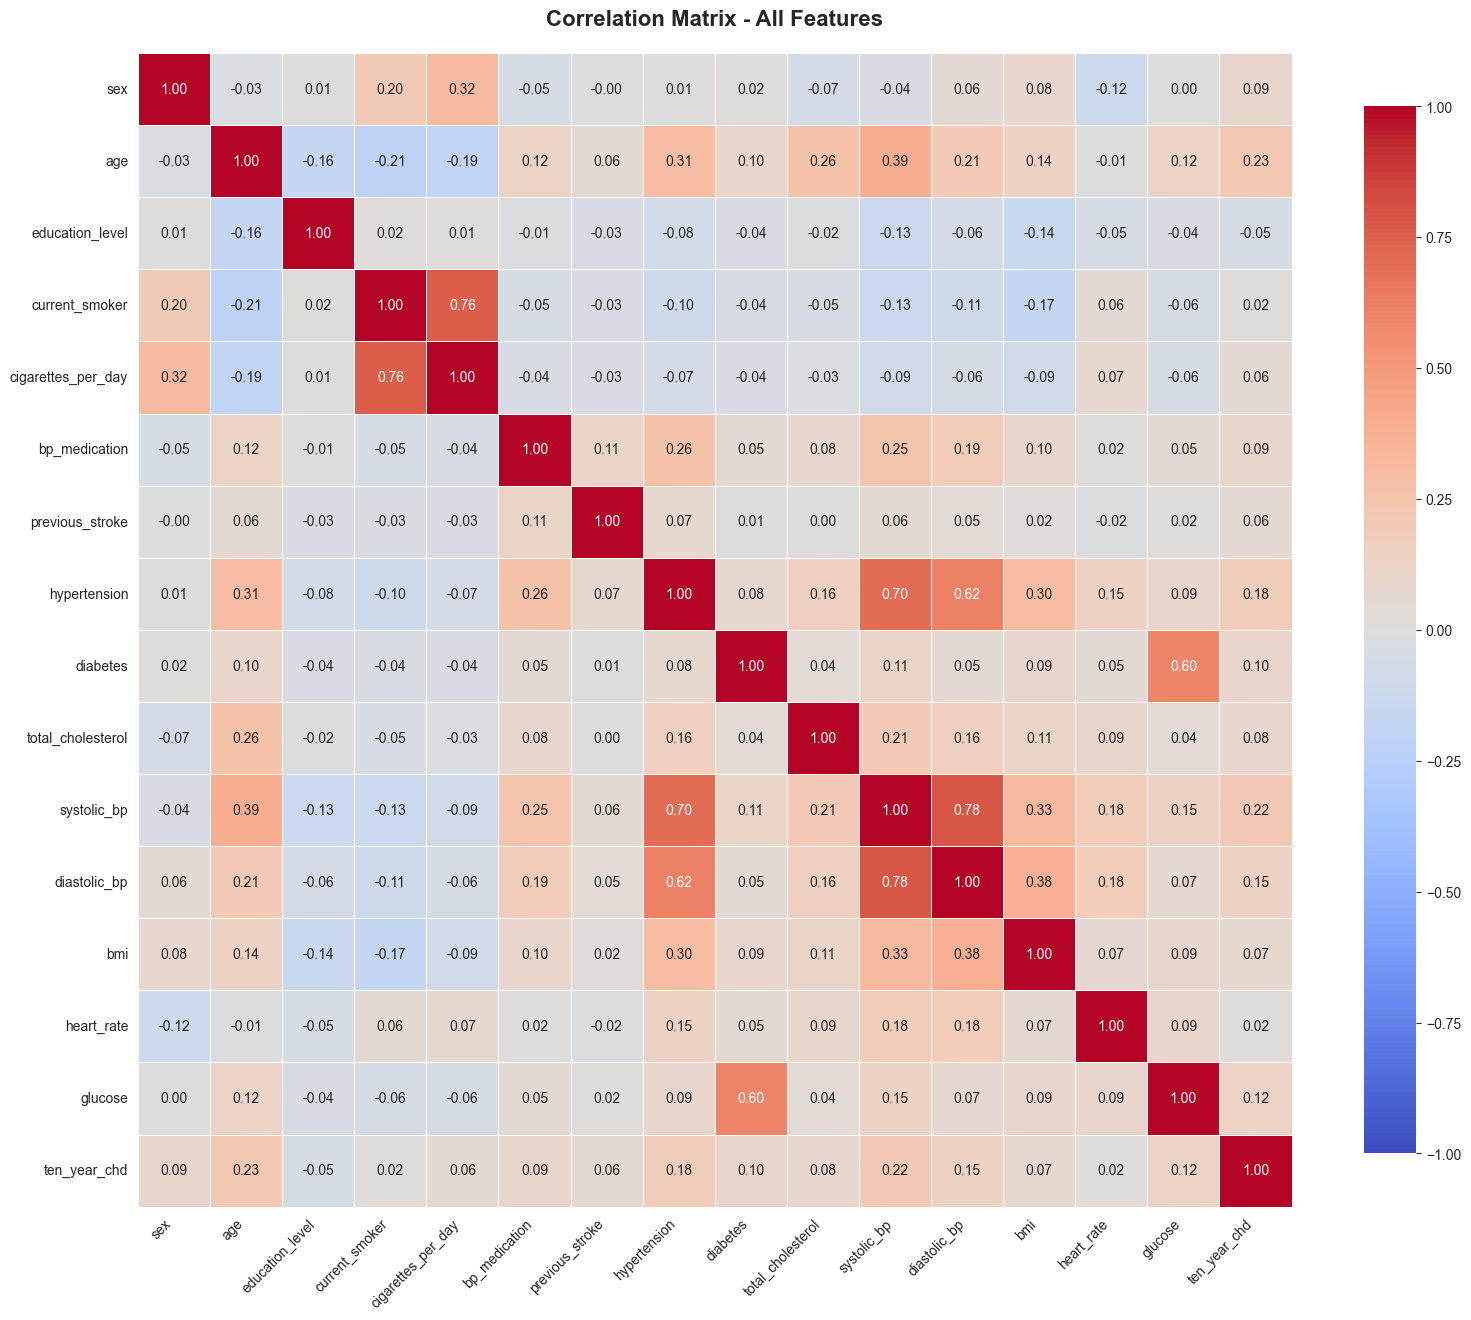

The most correlated variables are:
       Variable 1         Variable 2  Correlation  Abs_Correlation
      systolic_bp       diastolic_bp     0.784002         0.784002
   current_smoker cigarettes_per_day     0.760239         0.760239
     hypertension        systolic_bp     0.696755         0.696755
     hypertension       diastolic_bp     0.615751         0.615751
         diabetes            glucose     0.601494         0.601494
              age        systolic_bp     0.394302         0.394302
     diastolic_bp                bmi     0.376623         0.376623
      systolic_bp                bmi     0.325161         0.325161
              sex cigarettes_per_day     0.315630         0.315630
              age       hypertension     0.307194         0.307194
     hypertension                bmi     0.300510         0.300510
              age  total_cholesterol     0.260105         0.260105
    bp_medication       hypertension     0.258697         0.258697
    bp_medication        sy

In [ ]:
# Correlation Matrix
correlation_matrix = df.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Correlation Matrix - All Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


print("The most correlated variables are:")

# Extraer pares de correlación
correlations_list = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlations_list.append({
            'Variable 1': correlation_matrix.columns[i],
            'Variable 2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

# Ordering the most correlated variables into a new dataframe
correlations_df = pd.DataFrame(correlations_list)
correlations_df['Abs_Correlation'] = correlations_df['Correlation'].abs()
correlations_df_sorted = correlations_df.sort_values('Abs_Correlation', ascending=False)

print(correlations_df_sorted.head(20).to_string(index=False))





# Guide for analizing if a variable is highly correlated or not
print("Guide for analyzing how correlated are two variables")
print("""
Correlation Values (r):
  • |r| = 0.00 - 0.19  →  Very Weak Correlation
  • |r| = 0.20 - 0.39  →  Weak Correlation
  • |r| = 0.40 - 0.59  →  Moderated Correlation
  • |r| = 0.60 - 0.79  →  Strong Correlation
  • |r| = 0.80 - 1.00  →  Very Strong Correlation

Correlation Sign:
  • Positive (+): If the variable increases the target increases
  • Negative (-): If the variable increases the target decreases

""")

                         age  cigarettes_per_day  total_cholesterol  \
age                 1.000000           -0.191847           0.260105   
cigarettes_per_day -0.191847            1.000000          -0.026976   
total_cholesterol   0.260105           -0.026976           1.000000   
systolic_bp         0.394302           -0.088375           0.207522   
diastolic_bp        0.206104           -0.056687           0.163888   
bmi                 0.135174           -0.092211           0.114811   
heart_rate         -0.012848            0.073853           0.090537   
glucose             0.124679           -0.061275           0.044120   

                    systolic_bp  diastolic_bp       bmi  heart_rate   glucose  
age                    0.394302      0.206104  0.135174   -0.012848  0.124679  
cigarettes_per_day    -0.088375     -0.056687 -0.092211    0.073853 -0.061275  
total_cholesterol      0.207522      0.163888  0.114811    0.090537  0.044120  
systolic_bp            1.000000      0.7

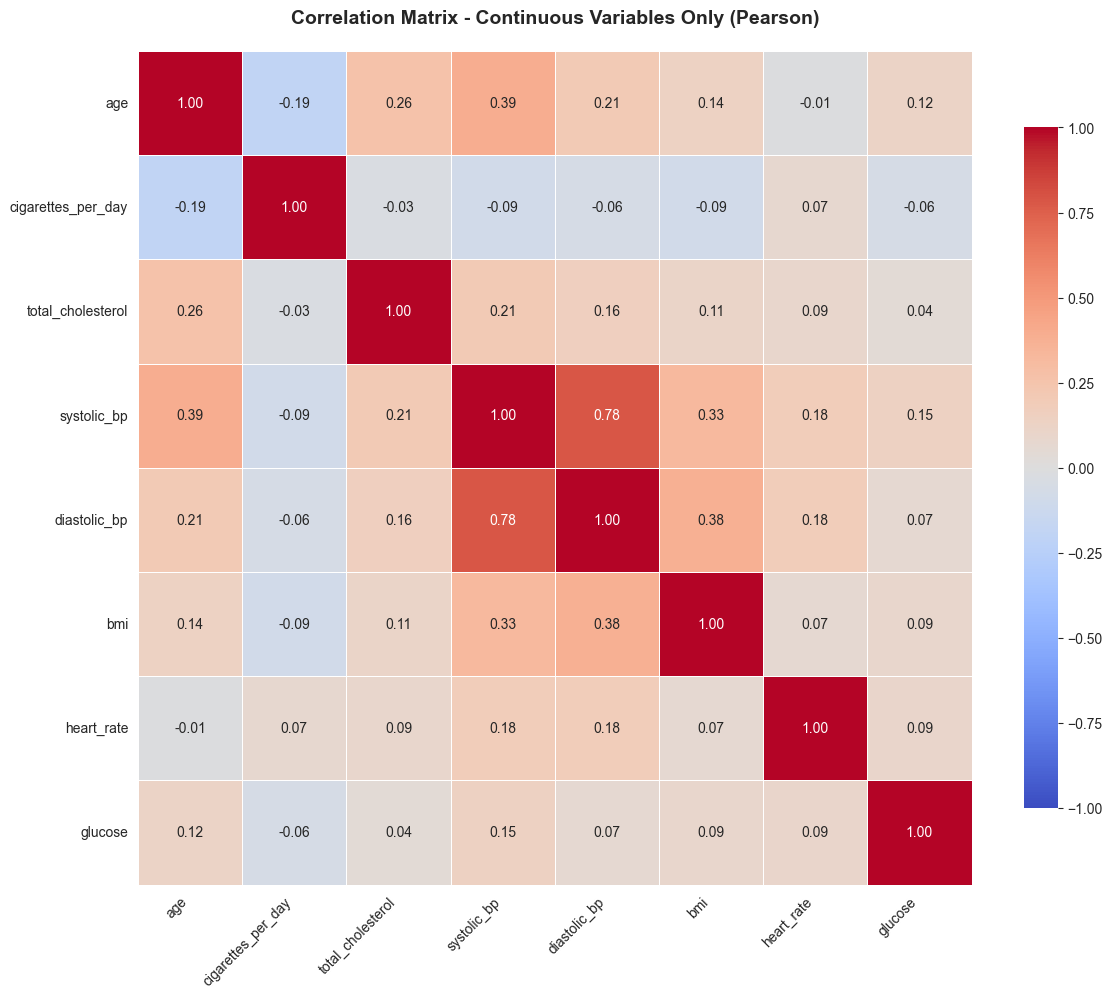

In [22]:
#Correlation between numerical variables

correlation_continuous = df[continuous_cols].corr()
print(correlation_continuous)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_continuous,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Correlation Matrix - Continuous Variables Only (Pearson)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

                      sex  education_level  current_smoker  bp_medication  \
sex              1.000000         0.013299        0.197596      -0.051545   
education_level  0.013299         1.000000        0.019403      -0.010149   
current_smoker   0.197596         0.019403        1.000000      -0.048358   
bp_medication   -0.051545        -0.010149       -0.048358       1.000000   
previous_stroke -0.004546        -0.032881       -0.032988       0.114609   
hypertension     0.005313        -0.078807       -0.103260       0.258697   
diabetes         0.015708        -0.038147       -0.044295       0.051394   
ten_year_chd     0.088428        -0.052812        0.019456       0.086417   

                 previous_stroke  hypertension  diabetes  ten_year_chd  
sex                    -0.004546      0.005313  0.015708      0.088428  
education_level        -0.032881     -0.078807 -0.038147     -0.052812  
current_smoker         -0.032988     -0.103260 -0.044295      0.019456  
bp_medication 

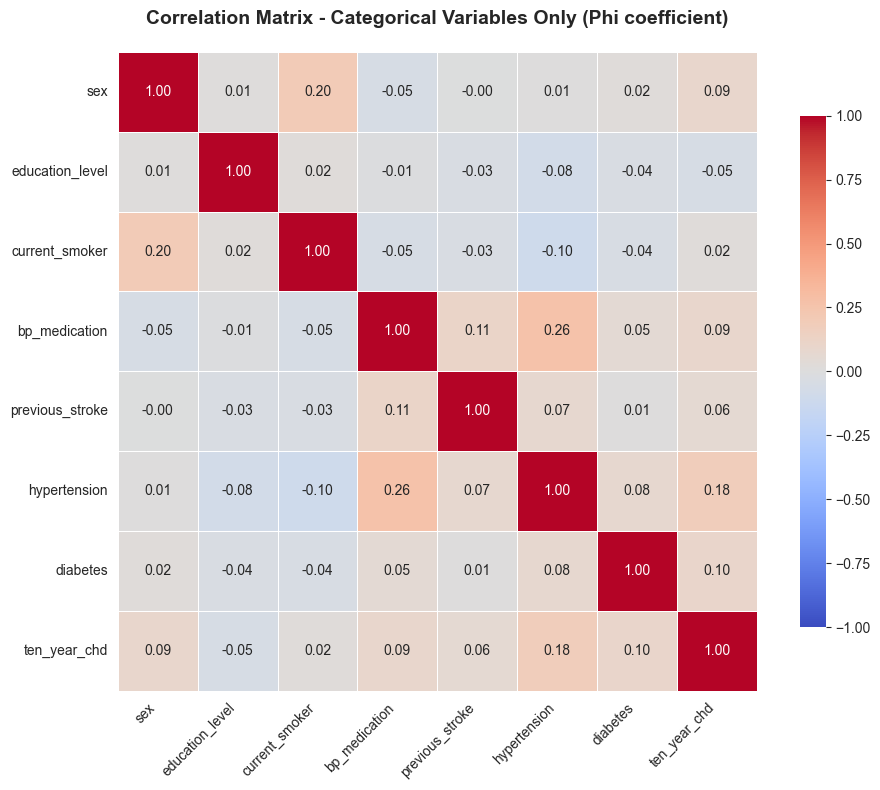

In [23]:
#Only categorical
correlation_categorical = df[categorical_cols].corr()
print(correlation_categorical)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_categorical,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Correlation Matrix - Categorical Variables Only (Phi coefficient)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

          Variable  Correlation
               age     0.225256
       systolic_bp     0.216429
      hypertension     0.177603
      diastolic_bp     0.145299
           glucose     0.123058
          diabetes     0.097317
               sex     0.088428
     bp_medication     0.086417
 total_cholesterol     0.081566
               bmi     0.074217
   previous_stroke     0.061810
cigarettes_per_day     0.058859
        heart_rate     0.022857
    current_smoker     0.019456
   education_level    -0.052812


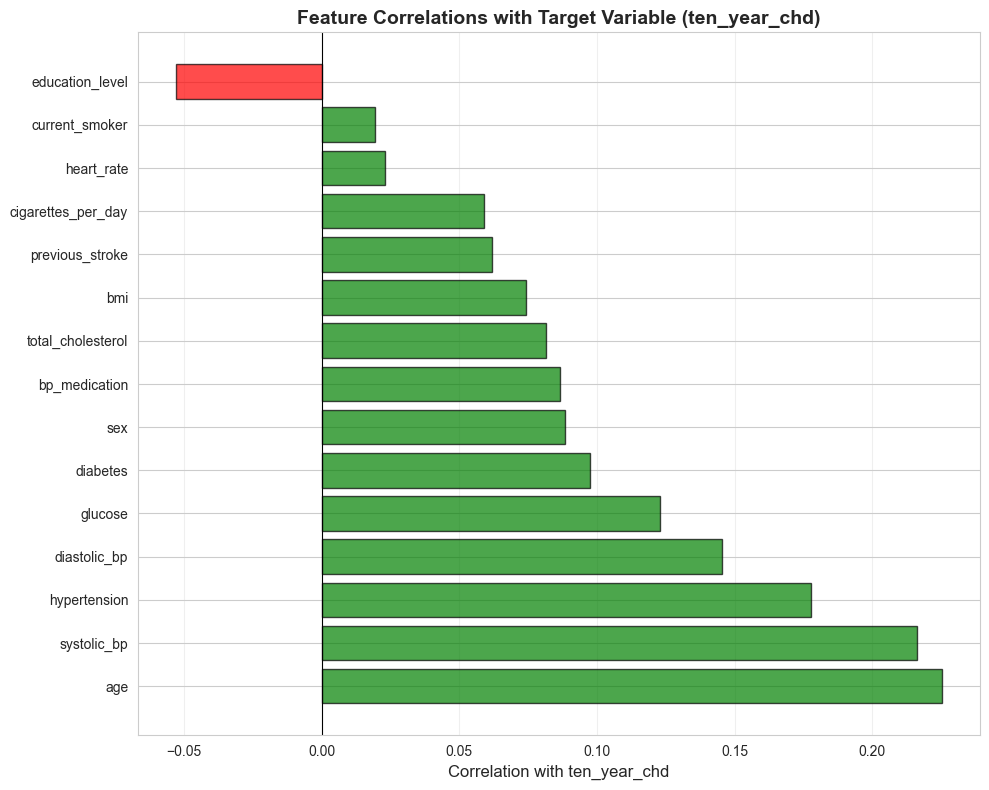

In [24]:
#Observing which are the correlation between some of our variables and having a previous heart cardiac disease from 10 years now on

if 'ten_year_chd' in df.columns:

    target_correlations = correlation_matrix['ten_year_chd'].drop('ten_year_chd').sort_values(ascending=False)

    target_corr_df = pd.DataFrame({
        'Variable': target_correlations.index,
        'Correlation': target_correlations.values
    })

    print(target_corr_df.to_string(index=False))


    plt.figure(figsize=(10, 8))
    colors = ['green' if x > 0 else 'red' for x in target_correlations.values]
    plt.barh(target_correlations.index, target_correlations.values, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel('Correlation with ten_year_chd', fontsize=12)
    plt.title('Feature Correlations with Target Variable (ten_year_chd)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()



 Analizing: age


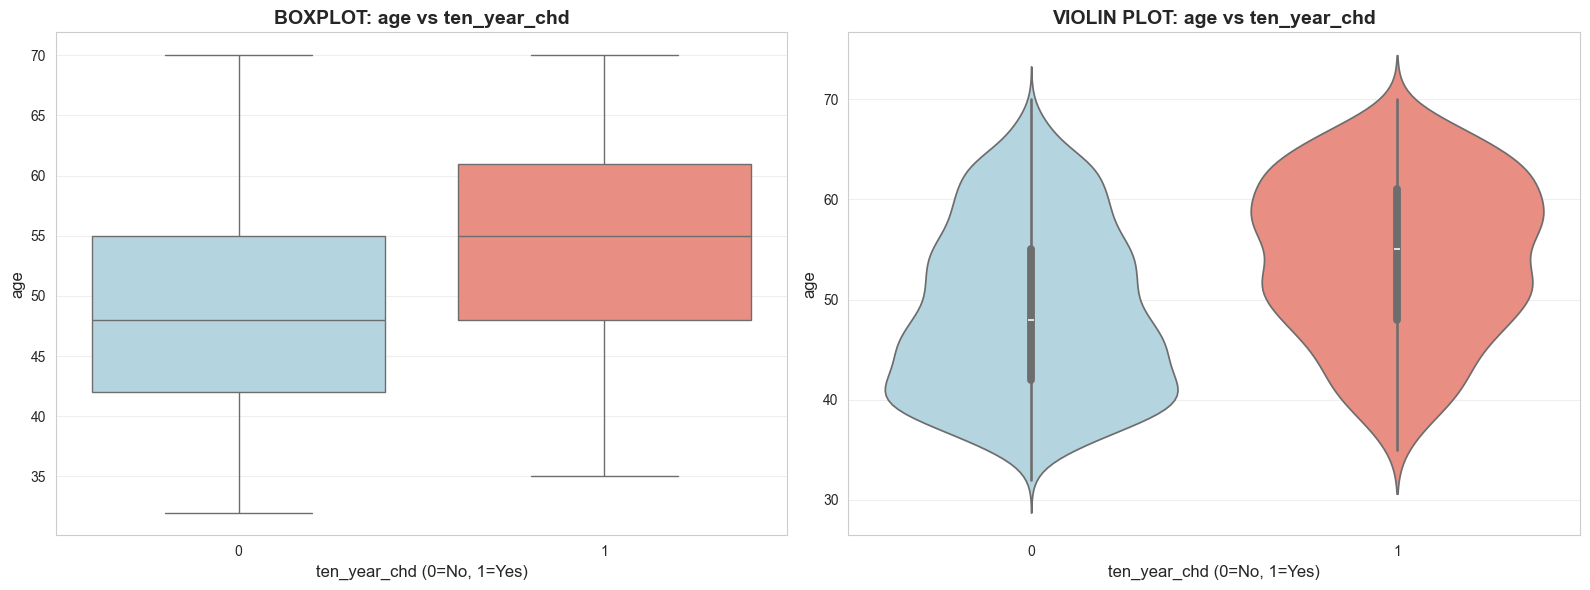


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               48.00           55.00           7.00            (+14.6%)
  Mean                 48.77           54.15           5.38           
  Std                  8.41            8.01            -0.41          

 Analizing: cigarettes_per_day


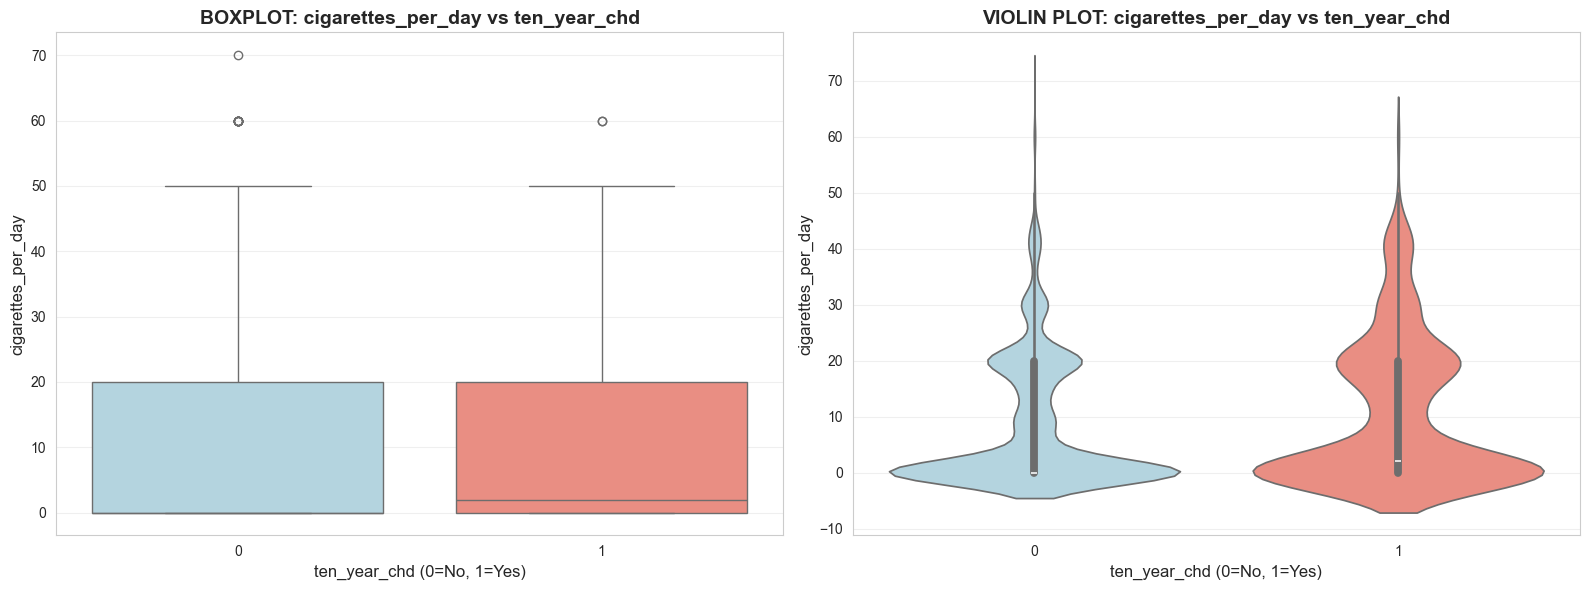


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               0.00            2.00            2.00            (+0.0%)
  Mean                 8.64            10.60           1.95           
  Std                  11.67           13.00           1.33           

 Analizing: total_cholesterol


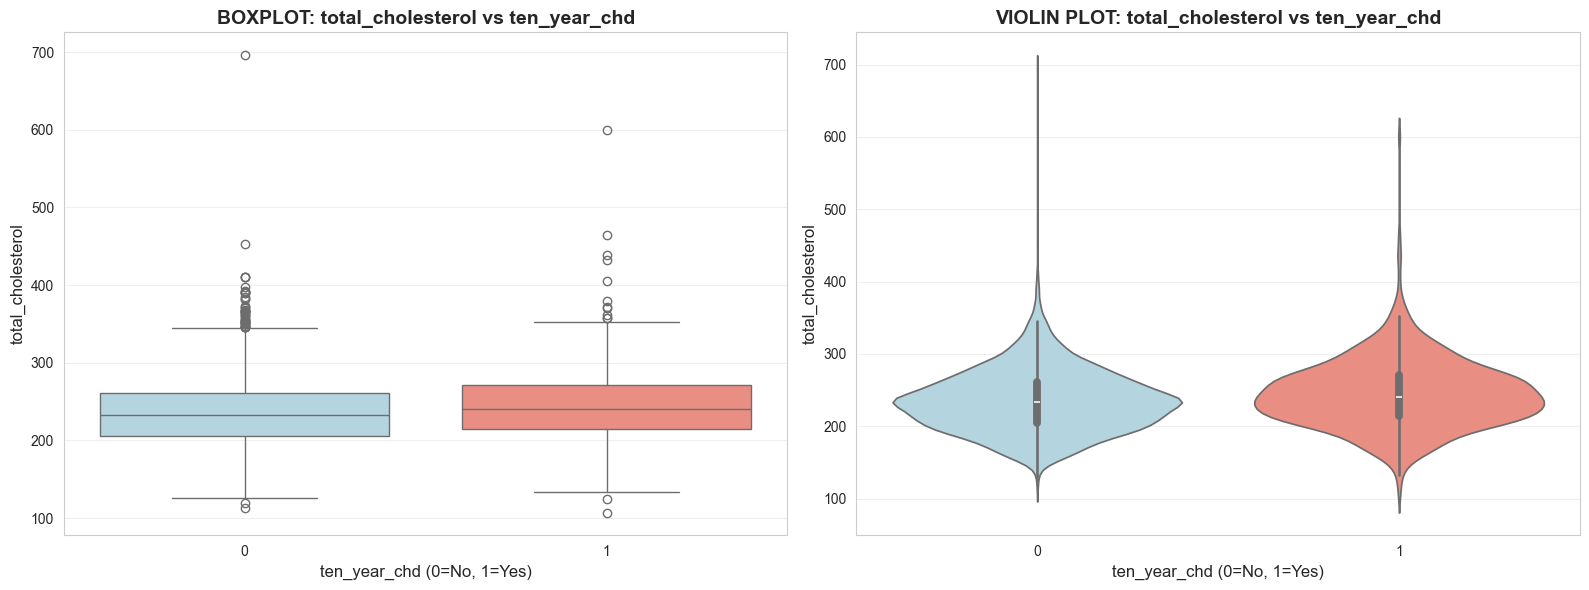


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               233.00          240.50          7.50            (+3.2%)
  Mean                 235.16          245.23          10.07          
  Std                  43.51           47.76           4.24           

 Analizing: systolic_bp


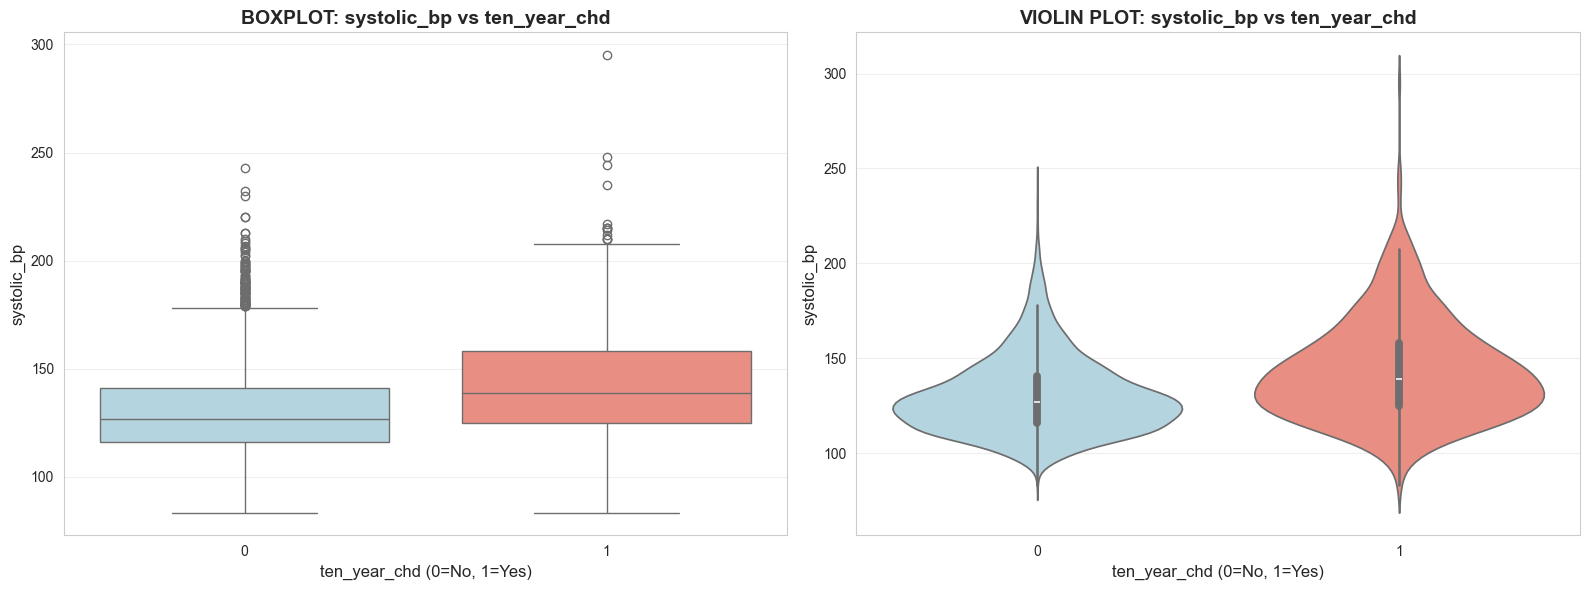


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               127.00          139.00          12.00           (+9.4%)
  Mean                 130.33          143.62          13.29          
  Std                  20.46           26.69           6.24           

 Analizing: diastolic_bp


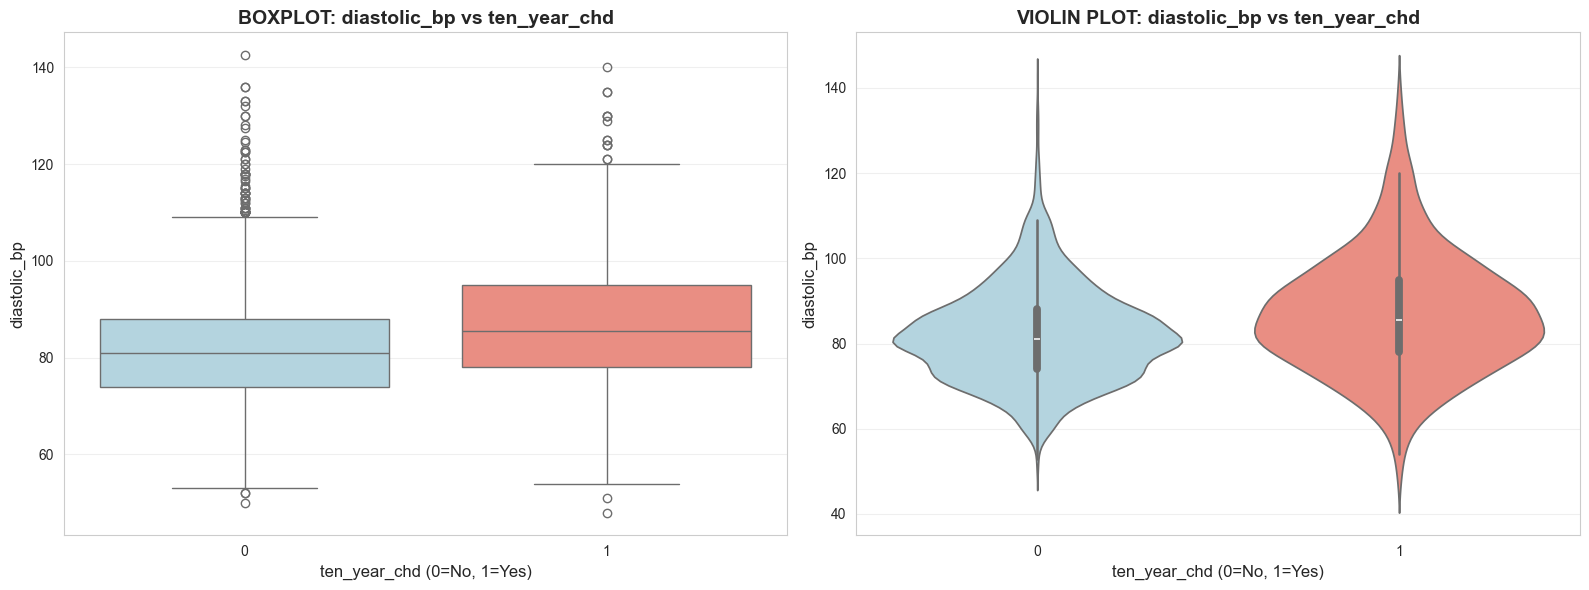


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               81.00           85.50           4.50            (+5.6%)
  Mean                 82.16           86.98           4.82           
  Std                  11.34           14.03           2.69           

 Analizing: bmi


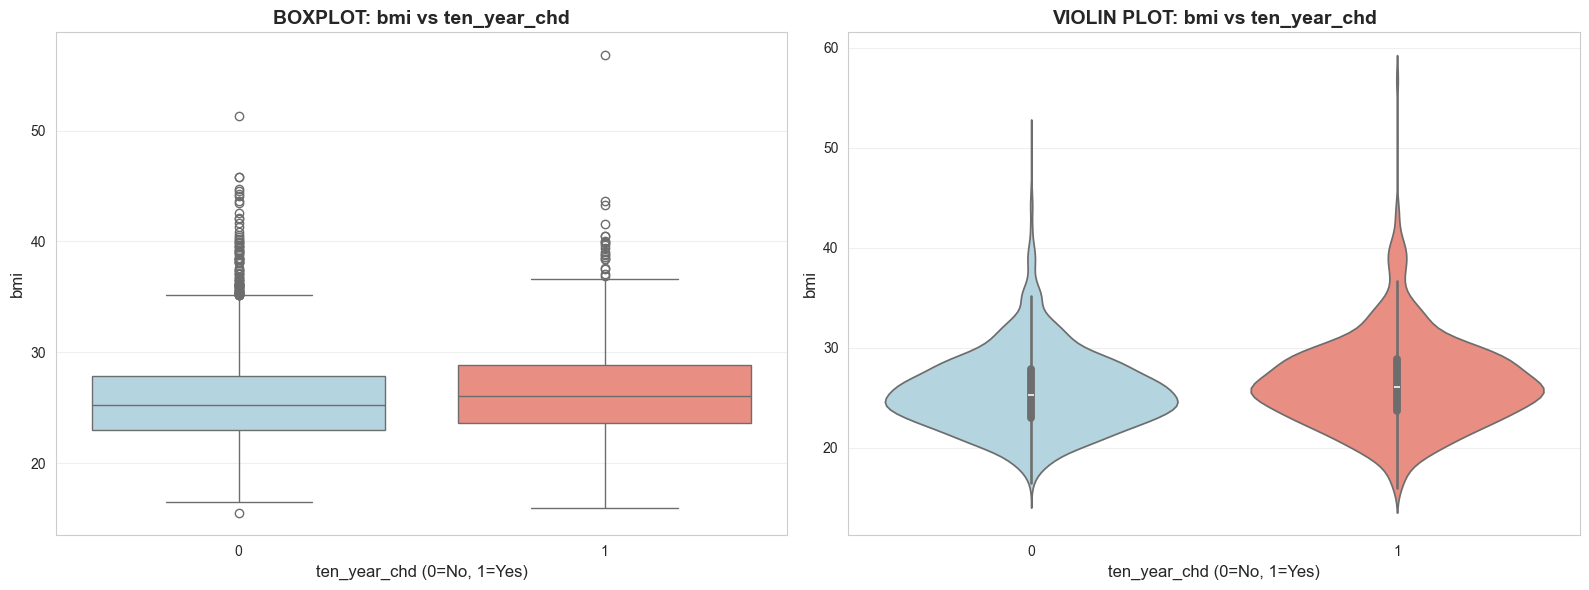


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               25.26           26.09           0.83            (+3.3%)
  Mean                 25.67           26.51           0.84           
  Std                  3.98            4.49            0.51           

 Analizing: heart_rate


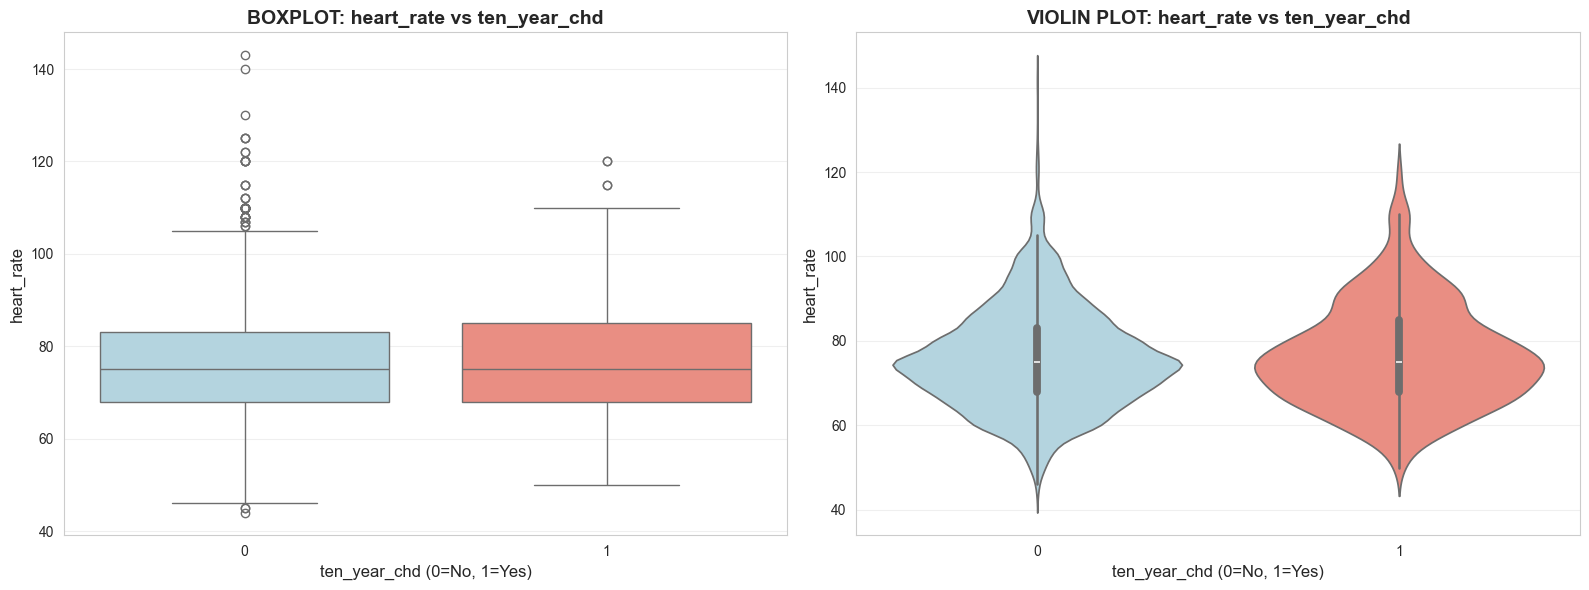


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               75.00           75.00           0.00            (+0.0%)
  Mean                 75.76           76.53           0.77           
  Std                  11.99           12.21           0.22           

 Analizing: glucose


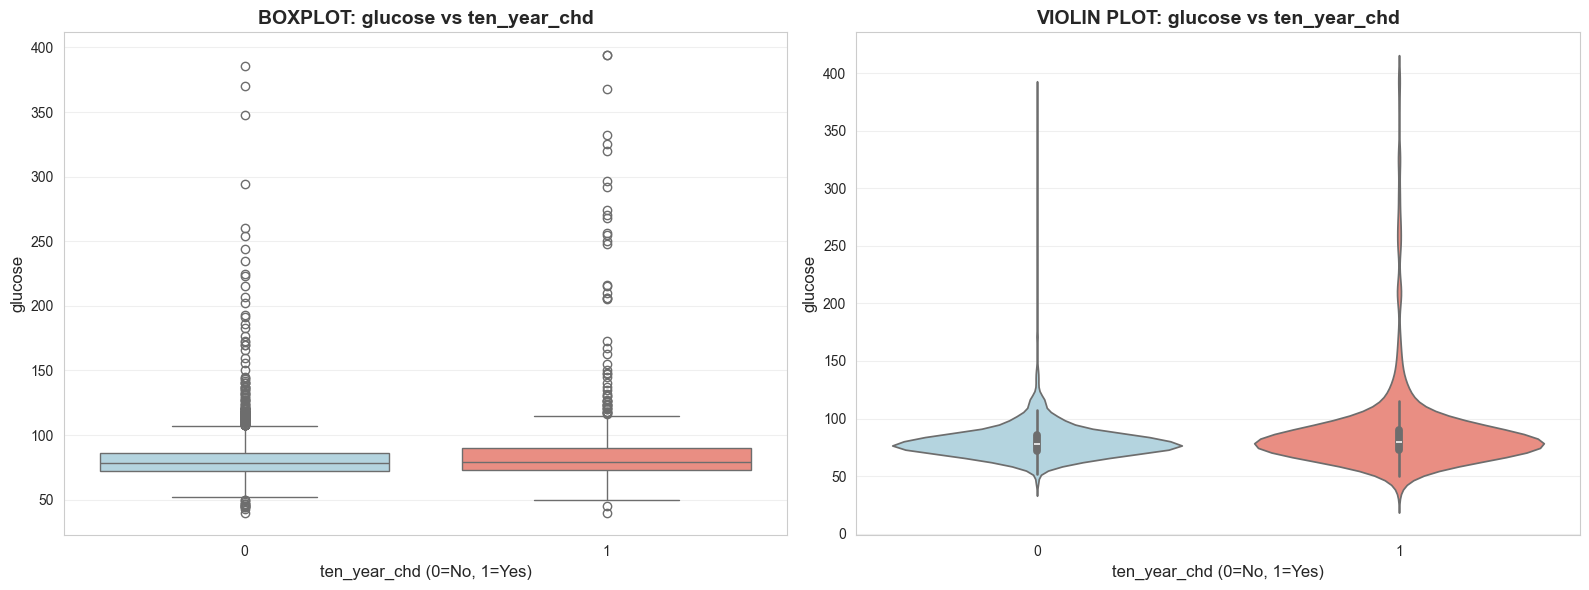


  Comparative Statistics:
  Metric               CHD=0           CHD=1           Diference      
  -----------------------------------------------------------------
  Median               78.00           79.50           1.50            (+1.9%)
  Mean                 80.70           88.58           7.89           
  Std                  18.26           39.64           21.38          


In [26]:
# Style
target = 'ten_year_chd'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


#Boxplot and Violin Plot for analyzing continuous variables vs Target Variable


for col in continuous_cols:
    if col in df.columns and target in df.columns:
        print(f"\n Analizing: {col}")

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # BOXPLOT
        sns.boxplot(data=df, x=target, y=col, hue=target, ax=axes[0],
                   palette=['lightblue', 'salmon'], legend=False)
        axes[0].set_title(f'BOXPLOT: {col} vs {target}',
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('ten_year_chd (0=No, 1=Yes)', fontsize=12)
        axes[0].set_ylabel(col, fontsize=12)
        axes[0].grid(axis='y', alpha=0.3)

        # VIOLIN PLOT
        sns.violinplot(data=df, x=target, y=col, hue=target, ax=axes[1],
                      palette=['lightblue', 'salmon'], inner='box', legend=False)
        axes[1].set_title(f'VIOLIN PLOT: {col} vs {target}',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('ten_year_chd (0=No, 1=Yes)', fontsize=12)
        axes[1].set_ylabel(col, fontsize=12)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Calculation of statistics
        group_0 = df[df[target] == 0][col].dropna()
        group_1 = df[df[target] == 1][col].dropna()

        median_0 = group_0.median()
        median_1 = group_1.median()
        mean_0 = group_0.mean()
        mean_1 = group_1.mean()
        std_0 = group_0.std()
        std_1 = group_1.std()

        diff_median = median_1 - median_0
        diff_mean = mean_1 - mean_0
        pct_diff = (diff_median / median_0 * 100) if median_0 != 0 else 0

        print(f"\n  Comparative Statistics:")
        print(f"  {'Metric':<20} {'CHD=0':<15} {'CHD=1':<15} {'Diference':<15}")
        print(f"  {'-'*65}")
        print(f"  {'Median':<20} {median_0:<15.2f} {median_1:<15.2f} {diff_median:<15.2f} ({pct_diff:+.1f}%)")
        print(f"  {'Mean':<20} {mean_0:<15.2f} {mean_1:<15.2f} {diff_mean:<15.2f}")
        print(f"  {'Std':<20} {std_0:<15.2f} {std_1:<15.2f} {std_1-std_0:<15.2f}")


        # Variance coeficient calculation
        cv_0 = (std_0 / mean_0) if mean_0 != 0 else 0
        cv_1 = (std_1 / mean_1) if mean_1 != 0 else 0



 Analyzing: sex


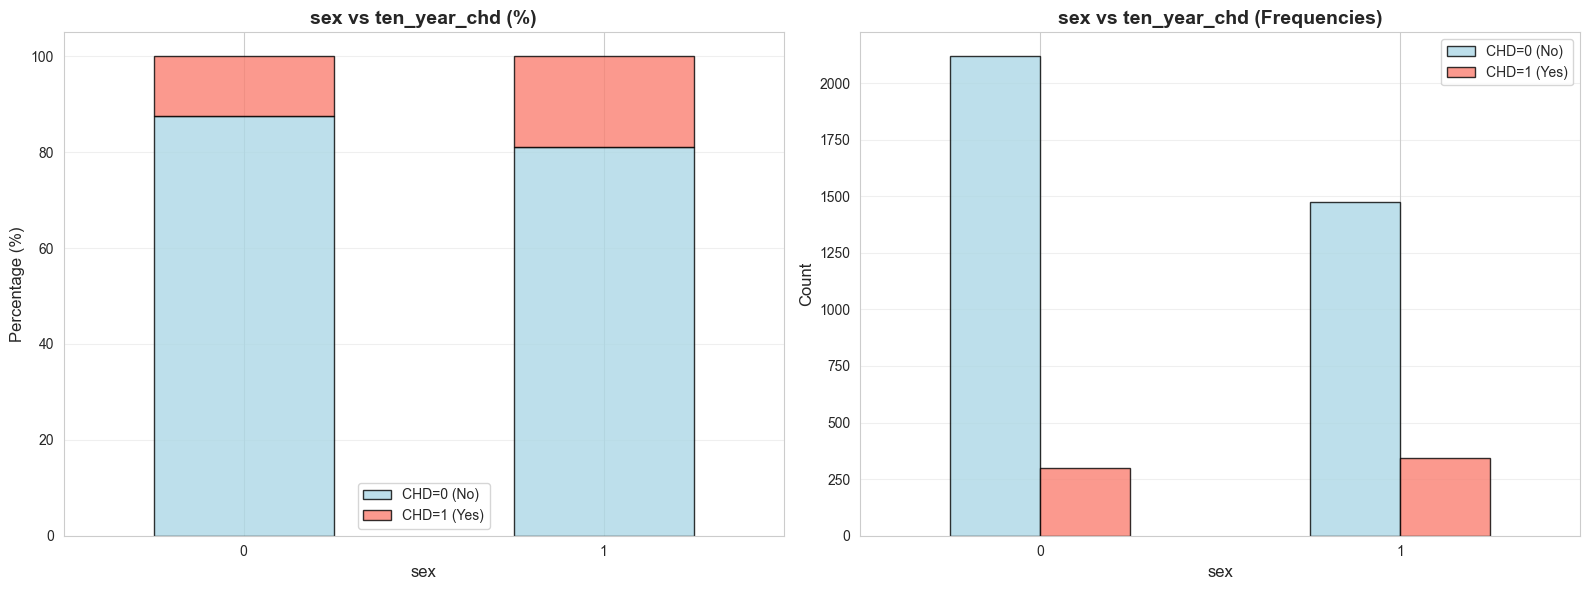

ten_year_chd      0      1
sex                       
0             87.56  12.44
1             81.14  18.86

  CHD Rate for each category:
    sex=1: 18.86% CHD (n=1819)
    sex=0: 12.44% CHD (n=2419)

  Interpretation:
     Small Difference: 6.4 statistical points
     → Limited Impact when predicting CHD

 Analyzing: education_level


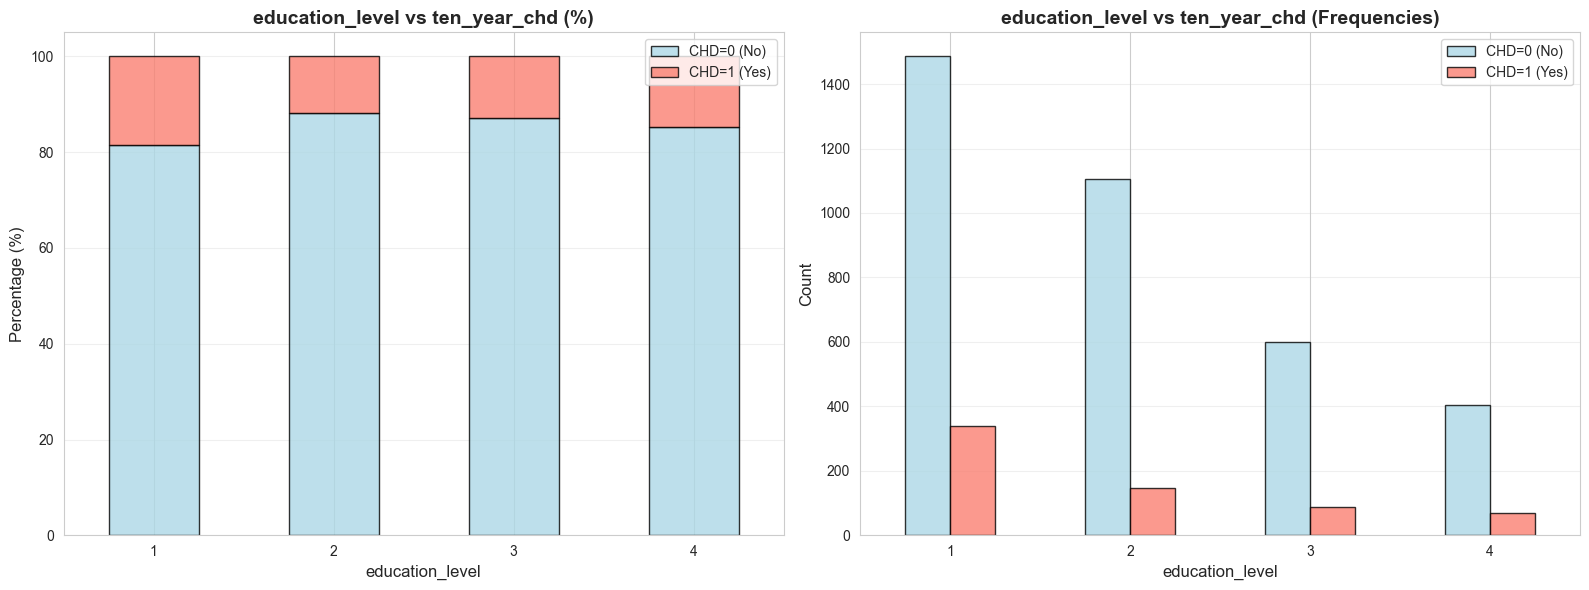

ten_year_chd         0      1
education_level              
1                81.42  18.58
2                88.27  11.73
3                87.19  12.81
4                85.20  14.80

  CHD Rate for each category:
    education_level=4: 14.80% CHD (n=473)
    education_level=2: 11.73% CHD (n=1253)
    education_level=1: 18.58% CHD (n=1825)
    education_level=3: 12.81% CHD (n=687)

  Interpretation:
     Small Difference: 6.8 statistical points
     → Limited Impact when predicting CHD

 Analyzing: current_smoker


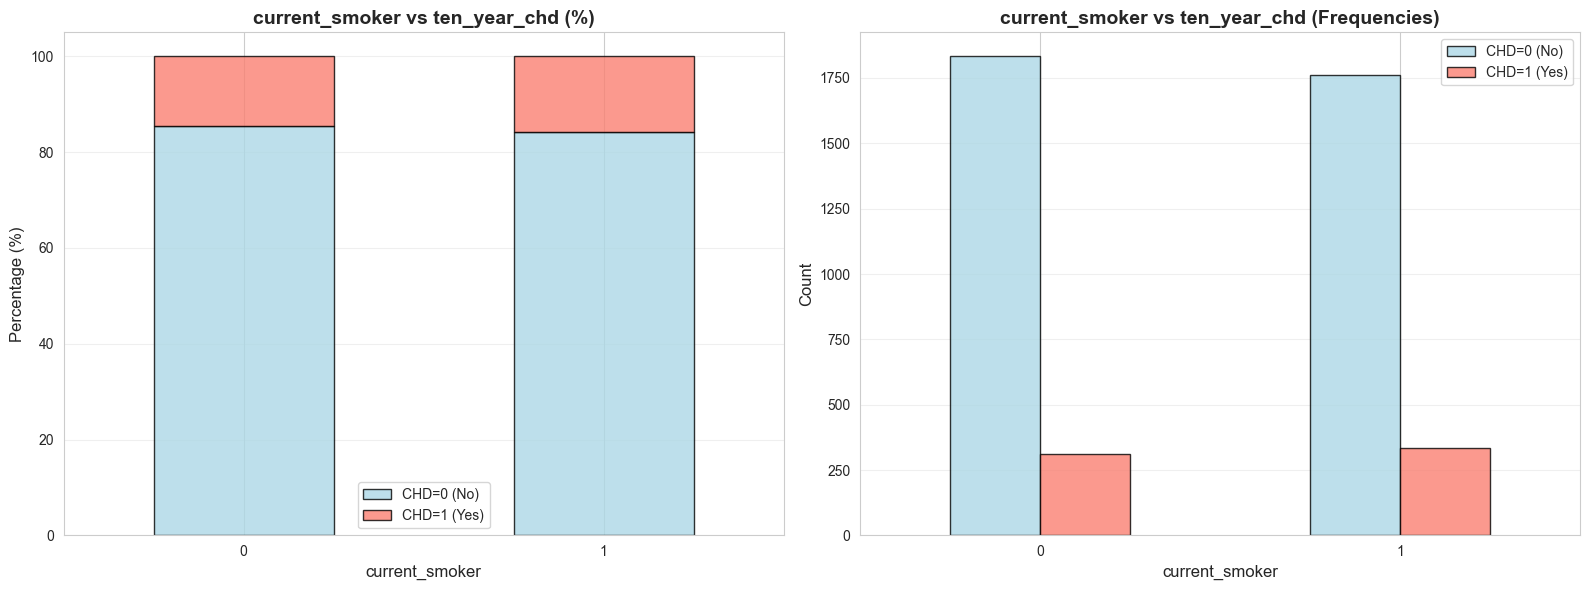

ten_year_chd        0      1
current_smoker              
0               85.49  14.51
1               84.10  15.90

  CHD Rate for each category:
    current_smoker=0: 14.51% CHD (n=2144)
    current_smoker=1: 15.90% CHD (n=2094)

  Interpretation:
     Small Difference: 1.4 statistical points
     → Limited Impact when predicting CHD

 Analyzing: bp_medication


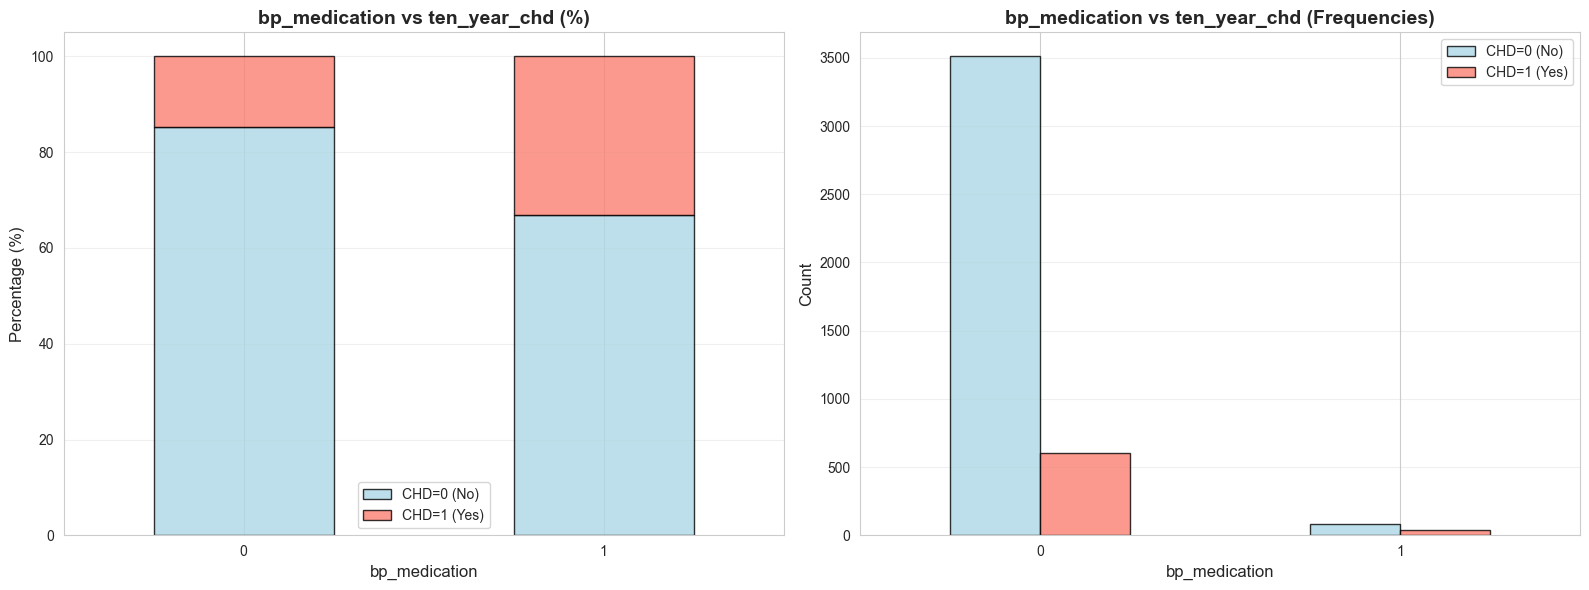

ten_year_chd       0      1
bp_medication              
0              85.34  14.66
1              66.94  33.06

  CHD Rate for each category:
    bp_medication=0: 14.66% CHD (n=4114)
    bp_medication=1: 33.06% CHD (n=124)

  Interpretation:
     Signicative Difference: 18.4 statistical points
     → Useful Variable for predicting CHD

 Analyzing: previous_stroke


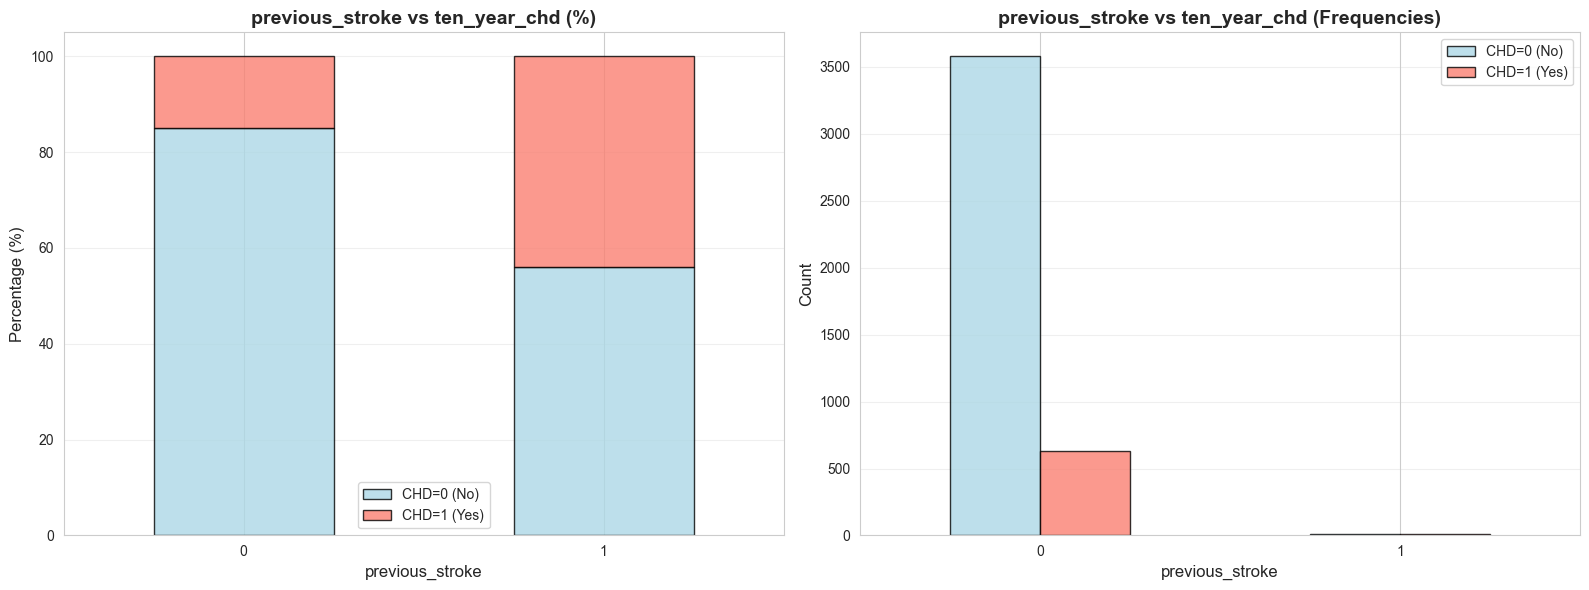

ten_year_chd         0      1
previous_stroke              
0                84.98  15.02
1                56.00  44.00

  CHD Rate for each category:
    previous_stroke=0: 15.02% CHD (n=4213)
    previous_stroke=1: 44.00% CHD (n=25)

  Interpretation:
     Signicative Difference: 29.0 statistical points
     → Useful Variable for predicting CHD

 Analyzing: hypertension


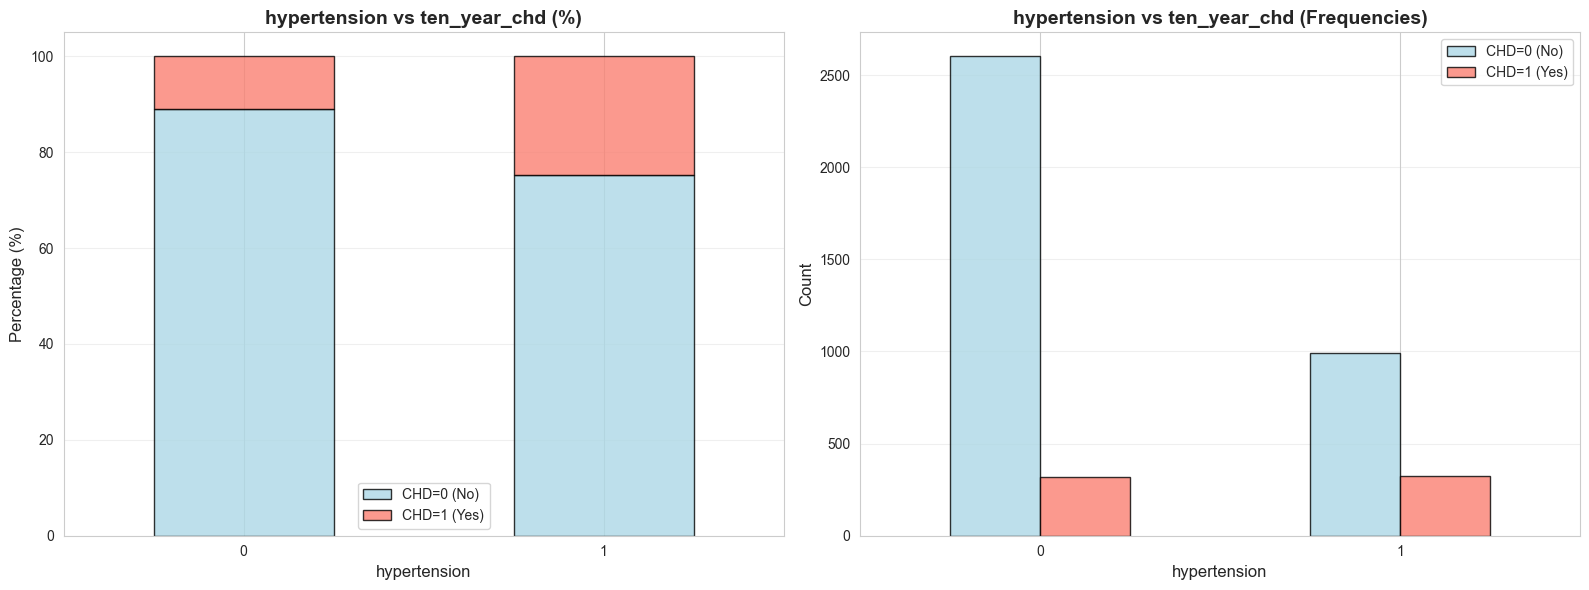

ten_year_chd      0      1
hypertension              
0             89.08  10.92
1             75.30  24.70

  CHD Rate for each category:
    hypertension=0: 10.92% CHD (n=2922)
    hypertension=1: 24.70% CHD (n=1316)

  Interpretation:
     Signicative Difference: 13.8 statistical points
     → Useful Variable for predicting CHD

 Analyzing: diabetes


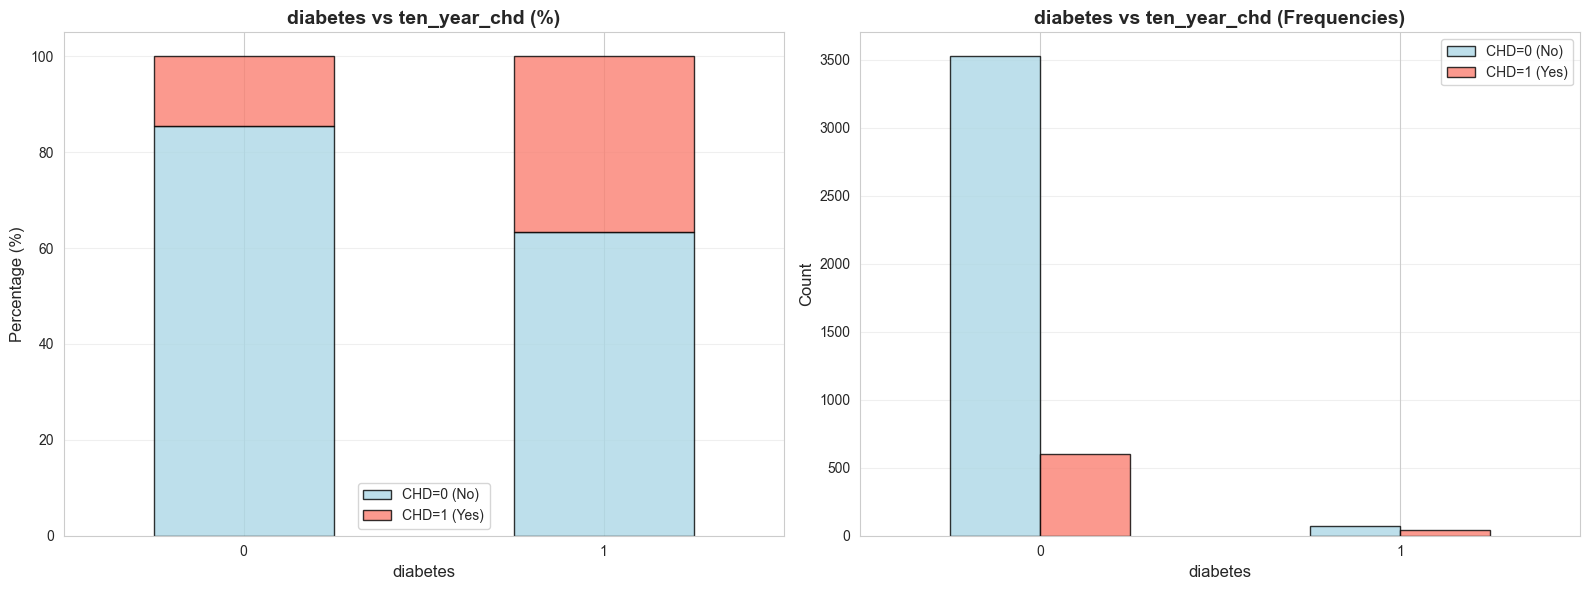

ten_year_chd      0      1
diabetes                  
0             85.37  14.63
1             63.30  36.70

  CHD Rate for each category:
    diabetes=0: 14.63% CHD (n=4129)
    diabetes=1: 36.70% CHD (n=109)

  Interpretation:
     Signicative Difference: 22.1 statistical points
     → Useful Variable for predicting CHD

 Analyzing: ten_year_chd


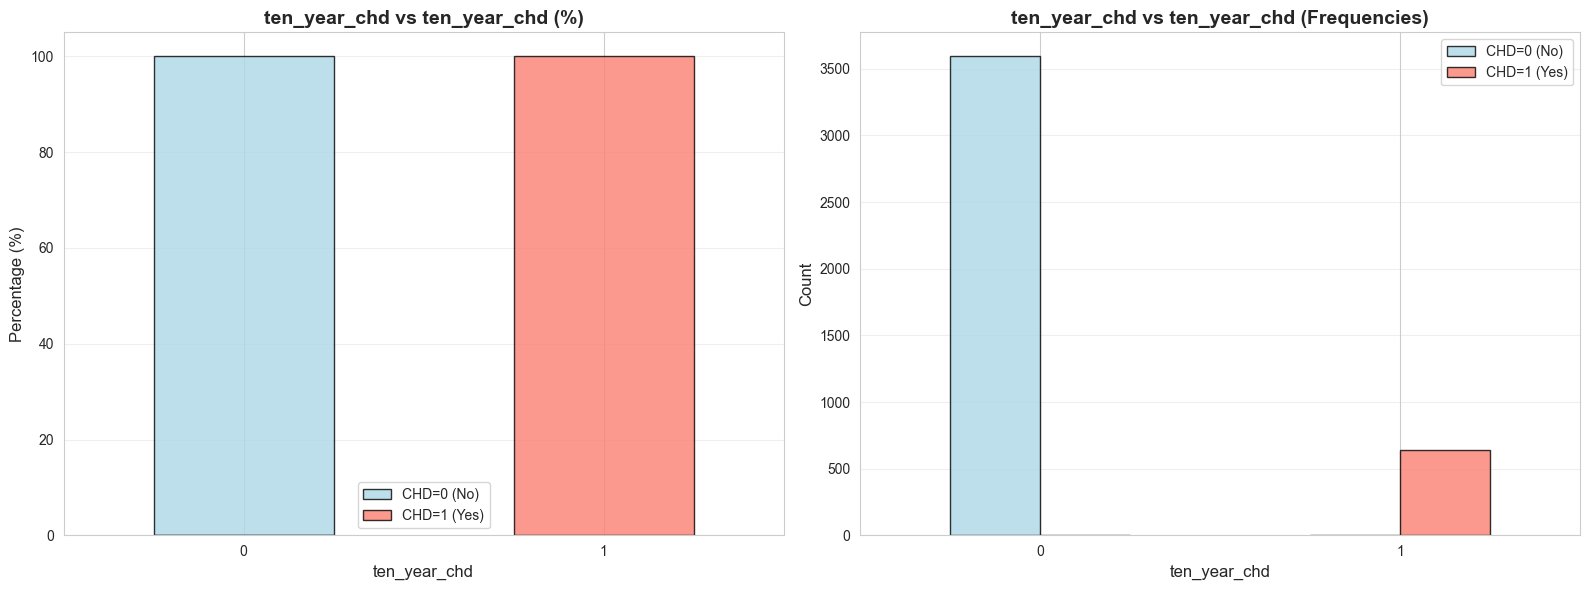

ten_year_chd      0      1
ten_year_chd              
0             100.0    0.0
1               0.0  100.0

  CHD Rate for each category:
    ten_year_chd=0: 0.00% CHD (n=3594)
    ten_year_chd=1: 100.00% CHD (n=644)

  Interpretation:
     Signicative Difference: 100.0 statistical points
     → Useful Variable for predicting CHD


In [27]:
for col in categorical_cols:
    if col in df.columns and target in df.columns:
        print(f"\n Analyzing: {col}")

        # Contingency Table
        contingency = pd.crosstab(df[col], df[target], normalize='index') * 100
        counts = pd.crosstab(df[col], df[target])

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Stacked Barplots
        contingency.plot(kind='bar', stacked=True, ax=axes[0],
                        color=['lightblue', 'salmon'], edgecolor='black', alpha=0.8)
        axes[0].set_title(f'{col} vs {target} (%)',
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel(col, fontsize=12)
        axes[0].set_ylabel('Percentage (%)', fontsize=12)
        axes[0].legend(['CHD=0 (No)', 'CHD=1 (Yes)'], loc='best')
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
        axes[0].grid(axis='y', alpha=0.3)

        # Grouped Absolute Frequencies
        counts.plot(kind='bar', ax=axes[1],
                   color=['lightblue', 'salmon'], edgecolor='black', alpha=0.8)
        axes[1].set_title(f'{col} vs {target} (Frequencies)',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel(col, fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].legend(['CHD=0 (No)', 'CHD=1 (Yes)'], loc='best')
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(contingency.round(2))

        # CHD Rate for each category
        print(f"\n  CHD Rate for each category:")
        for cat_val in df[col].dropna().unique():
            subset = df[df[col] == cat_val]
            chd_rate = (subset[target] == 1).sum() / len(subset) * 100
            n_total = len(subset)
            print(f"    {col}={cat_val}: {chd_rate:.2f}% CHD (n={n_total})")

        # Interpretación
        chd_rates = []
        for cat_val in df[col].dropna().unique():
            subset = df[df[col] == cat_val]
            rate = (subset[target] == 1).sum() / len(subset) * 100
            chd_rates.append(rate)

        max_rate = max(chd_rates)
        min_rate = min(chd_rates)
        diff_rate = max_rate - min_rate

        print(f"\n  Interpretation:")
        if diff_rate > 10:
            print(f"     Signicative Difference: {diff_rate:.1f} statistical points")
            print(f"     → Useful Variable for predicting CHD")
        else:
            print(f"     Small Difference: {diff_rate:.1f} statistical points")
            print(f"     → Limited Impact when predicting CHD")

CHI-SQUARE TEST OF INDEPENDENCE FOR CATEGORICAL VARIABLES

The chi-square test of independence evaluates whether two categorical
variables are statistically associated.

H0: The variables are independent
H1: The variables are associated

Decision rule:
  p-value < 0.05  -> Reject H0
  p-value ≥ 0.05  -> Fail to reject H0


VARIABLE: sex

1. Contingency table (observed frequencies):
ten_year_chd     0    1   All
sex                          
0             2118  301  2419
1             1476  343  1819
All           3594  644  4238

2. Row-wise percentages (% CHD per category):
ten_year_chd      0      1
sex                       
0             87.56  12.44
1             81.14  18.86

3. Chi-square test results:
   Chi-square statistic: 32.6430
   p-value: 0.000000
   Degrees of freedom: 1

4. Expected frequencies (under independence):
ten_year_chd        0       1
sex                          
0             2051.41  367.59
1             1542.59  276.41

5. Observed minus expected frequen

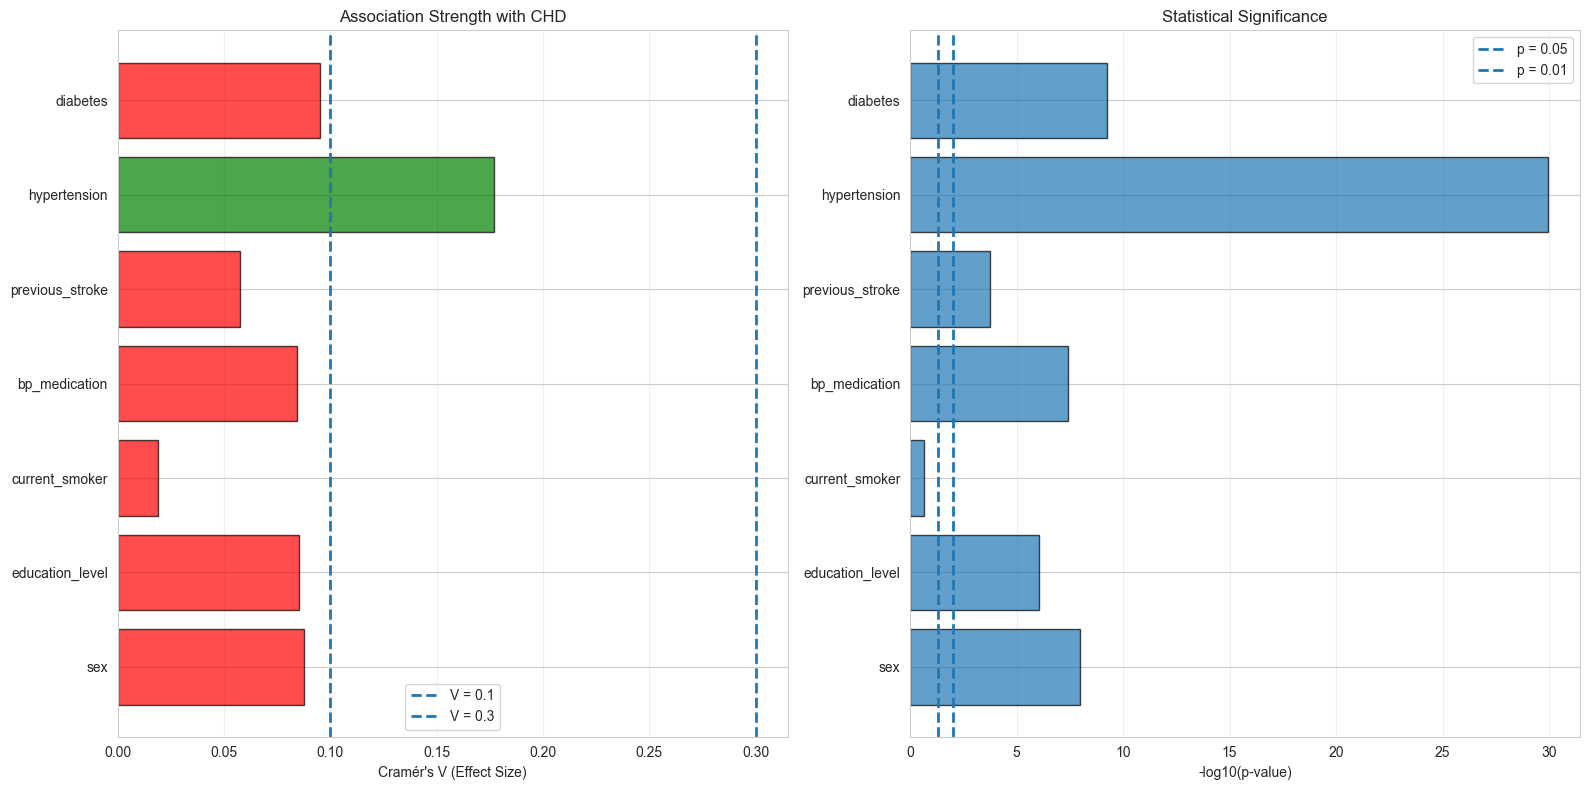

In [28]:
# Categorical variables and target definition

categorical_cols = ['sex', 'education_level','current_smoker', 'bp_medication', 'previous_stroke',
                    'hypertension', 'diabetes']

target = 'ten_year_chd'
print("CHI-SQUARE TEST OF INDEPENDENCE FOR CATEGORICAL VARIABLES")


print("""
The chi-square test of independence evaluates whether two categorical
variables are statistically associated.

H0: The variables are independent
H1: The variables are associated

Decision rule:
  p-value < 0.05  -> Reject H0
  p-value ≥ 0.05  -> Fail to reject H0
""")

def cramers_v(chi2, n, k, r):
    """
    Compute Cramér's V as an effect size for the chi-square test.
    """
    return np.sqrt(chi2 / (n * min(k - 1, r - 1)))


results = []

# ------------------------------------------------------------------
# Variable-wise analysis
# ------------------------------------------------------------------

for col in categorical_cols:
    if col in df.columns and target in df.columns:

        print("\n" + "=" * 80)
        print(f"VARIABLE: {col}")
        print("=" * 80)

        # Contingency table (observed frequencies)
        contingency_table = pd.crosstab(df[col], df[target])
        contingency_with_margins = pd.crosstab(df[col], df[target], margins=True)

        print("\n1. Contingency table (observed frequencies):")
        print(contingency_with_margins)

        # Row-wise percentages
        contingency_pct = (
            pd.crosstab(df[col], df[target], normalize='index') * 100
        )

        print("\n2. Row-wise percentages (% CHD per category):")
        print(contingency_pct.round(2))

        # Chi-square test
        chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

        print("\n3. Chi-square test results:")
        print(f"   Chi-square statistic: {chi2:.4f}")
        print(f"   p-value: {p_value:.6f}")
        print(f"   Degrees of freedom: {dof}")

        # Expected frequencies
        expected_df = pd.DataFrame(
            expected_freq,
            index=contingency_table.index,
            columns=contingency_table.columns
        )

        print("\n4. Expected frequencies (under independence):")
        print(expected_df.round(2))

        # Observed - expected
        diff = contingency_table - expected_df

        print("\n5. Observed minus expected frequencies:")
        print(diff.round(2))

        # Significance interpretation
        print("\n6. Statistical significance:")
        if p_value < 0.001:
            significance = "***"
            print("   Very strong evidence of association (p < 0.001)")
        elif p_value < 0.01:
            significance = "**"
            print("   Strong evidence of association (p < 0.01)")
        elif p_value < 0.05:
            significance = "*"
            print("   Evidence of association (p < 0.05)")
        else:
            significance = "ns"
            print("   No evidence of association (p ≥ 0.05)")

        # Effect size
        n = contingency_table.values.sum()
        k = contingency_table.shape[1]
        r = contingency_table.shape[0]

        cramers = cramers_v(chi2, n, k, r)

        print("\n7. Effect size (Cramér's V):")
        print(f"   V = {cramers:.4f}")

        if cramers < 0.1:
            effect_size = "negligible"
        elif cramers < 0.3:
            effect_size = "small"
        elif cramers < 0.5:
            effect_size = "moderate"
        else:
            effect_size = "large"

        print(f"   Effect size category: {effect_size}")

        # CHD prevalence per category
        print("\n8. CHD prevalence per category:")
        for cat_value in sorted(df[col].dropna().unique()):
            subset = df[df[col] == cat_value]
            n_total = len(subset)
            n_chd = (subset[target] == 1).sum()
            rate = (n_chd / n_total) * 100

            print(
                f"   {col} = {int(cat_value)}: "
                f"{rate:.2f}% CHD (n={n_total}, CHD cases={n_chd})"
            )

        # Assumption check
        min_expected = expected_df.min().min()

        print("\n9. Chi-square assumptions:")
        print(f"   Minimum expected frequency: {min_expected:.2f}")

        if min_expected < 5:
            print(
                "   Warning: Some expected frequencies are < 5. "
                "The chi-square approximation may be unreliable."
            )
        else:
            print("   All expected frequencies ≥ 5.")

        # Practical recommendation
        print("\n10. Practical recommendation:")

        is_useful = False
        criteria = []

        if p_value < 0.05:
            criteria.append(f"Statistically significant (p = {p_value:.4f})")
            if cramers >= 0.1:
                criteria.append(f"Non-negligible effect size (V = {cramers:.3f})")
                is_useful = True
            else:
                criteria.append(f"Negligible effect size (V = {cramers:.3f})")
        else:
            criteria.append(f"Not statistically significant (p = {p_value:.4f})")

        for c in criteria:
            print(f"   - {c}")

        if is_useful:
            print("   Conclusion: Variable potentially useful for CHD prediction.")
        else:
            print("   Conclusion: Variable has limited predictive value.")

        results.append({
            'Variable': col,
            'Chi2': chi2,
            'P_value': p_value,
            'Significance': significance,
            'Cramers_V': cramers,
            'Effect_Size': effect_size,
            'DOF': dof,
            'Min_Expected': min_expected,
            'Valid_Test': 'Yes' if min_expected >= 5 else 'No',
            'Useful': 'Yes' if is_useful else 'No'
        })

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Effect size ranking with original color logic
colors_cv = [
    'green' if row['Useful'] == 'Yes' else 'red'
    for _, row in results_df.iterrows()
]

axes[0].barh(
    results_df['Variable'],
    results_df['Cramers_V'],
    color=colors_cv,
    alpha=0.7,
    edgecolor='black'
)
axes[0].axvline(x=0.1, linestyle='--', linewidth=2, label='V = 0.1')
axes[0].axvline(x=0.3, linestyle='--', linewidth=2, label='V = 0.3')
axes[0].set_xlabel("Cramér's V (Effect Size)")
axes[0].set_title("Association Strength with CHD")
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# p-value ranking (log scale)
results_df['log_p'] = -np.log10(results_df['P_value'])

axes[1].barh(
    results_df['Variable'],
    results_df['log_p'],
    alpha=0.7,
    edgecolor='black'
)
axes[1].axvline(-np.log10(0.05), linestyle='--', linewidth=2, label='p = 0.05')
axes[1].axvline(-np.log10(0.01), linestyle='--', linewidth=2, label='p = 0.01')
axes[1].set_xlabel("-log10(p-value)")
axes[1].set_title("Statistical Significance")
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()




 Rank           Variable        Type  Effect_Size Effect_Metric  P_value  Importance_Score            Usefulness
    1                age  Continuous       0.6439     Cohen's d   0.0000           30.2198   Strong Significance
    2        systolic_bp  Continuous       0.6174     Cohen's d   0.0000           22.2308   Strong Significance
    3       diastolic_bp  Continuous       0.4090     Cohen's d   0.0000            6.9519 Moderate Significance
    4       hypertension Categorical       0.1769    Cramér's V   0.0000            5.2995    Small Significance
    5  total_cholesterol  Continuous       0.2279     Cohen's d   0.0000            1.4981 Moderate Significance
    6            glucose  Continuous       0.3453     Cohen's d   0.0003            1.2106 Moderate Significance
    7                bmi  Continuous       0.2073     Cohen's d   0.0000            1.1835 Moderate Significance
    8           diabetes Categorical       0.0952    Cramér's V   0.0000            0.8808      

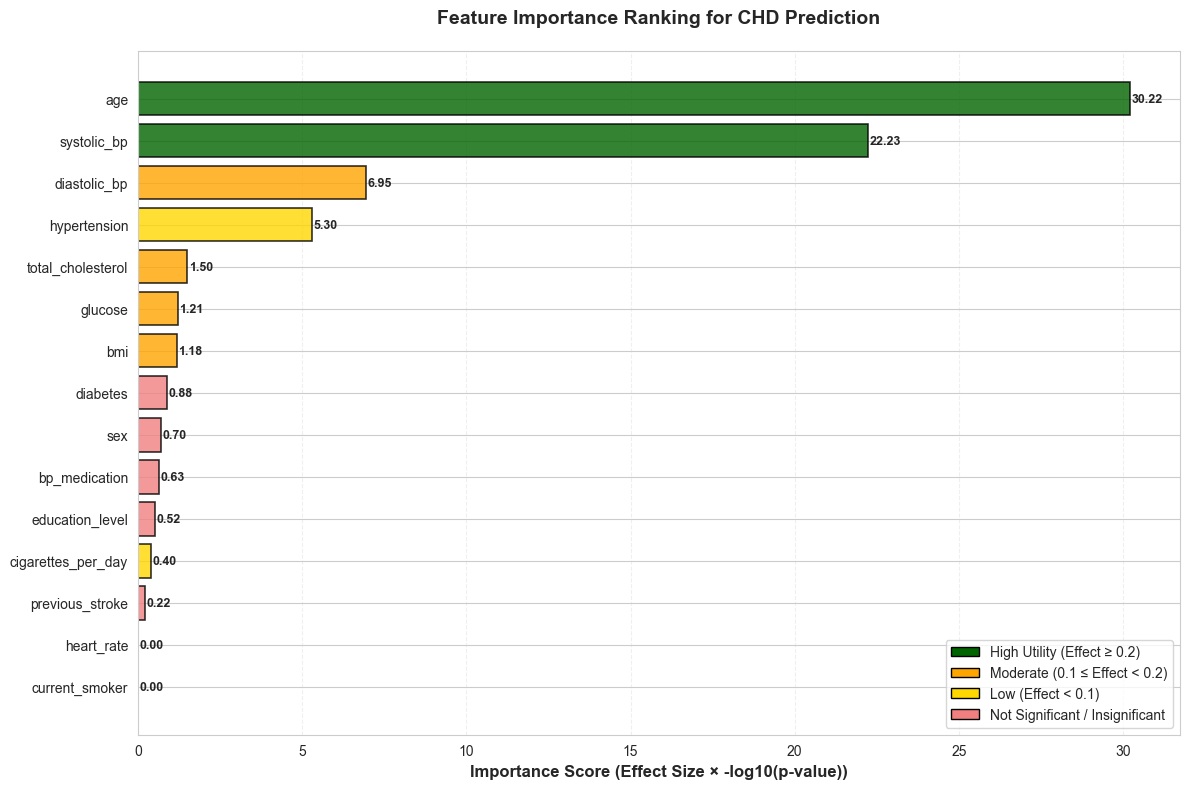


 FINAL RECOMMENDATIONS
 DEFINITELY INCLUDE (6 variables):
  • age
  • systolic_bp
  • diastolic_bp
  • total_cholesterol
  • glucose
  • bmi

 CONSIDER INCLUDING (2 variables):
  • hypertension
  • cigarettes_per_day

 LIKELY EXCLUDE (7 variables):
  • diabetes
  • sex
  • bp_medication
  • education_level
  • previous_stroke
  • heart_rate
  • current_smoker


In [30]:
def cohens_d(group1, group2):
    """Calculates Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def cramers_v(chi2, n, k, r):
    """Calculates Cramér's V effect size"""
    return np.sqrt(chi2 / (n * min(k-1, r-1)))

def calculate_importance_score(p_value, effect_size):
    """Combines p-value and effect size into a single importance score"""
    if p_value <= 0:
        p_value = 1e-300
    # Significance weight is based on the log of the p-value
    significance_weight = -np.log10(p_value) if p_value < 0.05 else 0
    return effect_size * significance_weight

# Utility classification logic and color mapping
USEFULNESS_LABELS = {
    'high': 'Strong Significance',
    'moderate': 'Moderate Significance',
    'low': 'Small Significance',
    'insignificant': 'Insignificant',
    'non_sig': 'Non-Significant'
}

COLOR_PALETTE = {
    USEFULNESS_LABELS['high']: 'darkgreen',
    USEFULNESS_LABELS['moderate']: 'orange',
    USEFULNESS_LABELS['low']: 'gold',
    USEFULNESS_LABELS['insignificant']: 'lightcoral',
    USEFULNESS_LABELS['non_sig']: 'lightcoral'
}

# Statistical Analysis

continuous_results = []
for col in continuous_cols:
    if col in df.columns and target in df.columns:
        group_0 = df[df[target] == 0][col].dropna()
        group_1 = df[df[target] == 1][col].dropna()

        _, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
        d = abs(cohens_d(group_0, group_1))
        importance = calculate_importance_score(p_value, d)

        continuous_results.append({
            'Variable': col,
            'Type': 'Continuous',
            'P_value': p_value,
            'Effect_Size': d,
            'Effect_Metric': "Cohen's d",
            'Importance_Score': importance
        })

categorical_results = []
for col in categorical_cols:
    if col in df.columns and target in df.columns:
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p_value, dof, _ = chi2_contingency(contingency_table)

        n = contingency_table.sum().sum()
        k = contingency_table.shape[1]
        r = contingency_table.shape[0]
        cramers = cramers_v(chi2, n, k, r)
        importance = calculate_importance_score(p_value, cramers)

        categorical_results.append({
            'Variable': col,
            'Type': 'Categorical',
            'P_value': p_value,
            'Effect_Size': cramers,
            'Effect_Metric': "Cramér's V",
            'Importance_Score': importance
        })

# Combine and rank results
results_df = pd.DataFrame(continuous_results + categorical_results)
results_df = results_df.sort_values('Importance_Score', ascending=False)
results_df['Rank'] = range(1, len(results_df) + 1)

def classify_usefulness(row):
    if row['P_value'] >= 0.05:
        return USEFULNESS_LABELS['non_sig']
    elif row['Effect_Size'] < 0.1:
        return USEFULNESS_LABELS['insignificant']
    elif row['Effect_Size'] < 0.2:
        return USEFULNESS_LABELS['low']
    elif row['Effect_Size'] < 0.5:
        return USEFULNESS_LABELS['moderate']
    else:
        return USEFULNESS_LABELS['high']

results_df['Usefulness'] = results_df.apply(classify_usefulness, axis=1)

# Display table
display_cols = ['Rank', 'Variable', 'Type', 'Effect_Size', 'Effect_Metric', 'P_value', 'Importance_Score', 'Usefulness']
pd.options.display.float_format = '{:.4f}'.format
print(results_df[display_cols].to_string(index=False))

#  Segmentation for Summary

highly_useful = results_df[(results_df['P_value'] < 0.05) & (results_df['Effect_Size'] >= 0.2)]
moderately_useful = results_df[(results_df['P_value'] < 0.05) & (results_df['Effect_Size'] >= 0.1) & (results_df['Effect_Size'] < 0.2)]
low_utility = results_df[(results_df['P_value'] < 0.05) & (results_df['Effect_Size'] < 0.1)]
not_significant = results_df[results_df['P_value'] >= 0.05]

print(f"\n High Usefulness (p<0.05 & Effect≥0.2): {len(highly_useful)} variables")
print(f" Moderated Usefulness (p<0.05 & 0.1≤Effect<0.2): {len(moderately_useful)} variables")
print(f" Non-significant (p≥0.05): {len(not_significant)} variables")

fig, ax = plt.subplots(figsize=(12, 8))

# Map colors directly from the dictionary
bar_colors = results_df['Usefulness'].map(COLOR_PALETTE).fillna('grey')

bars = ax.barh(results_df['Variable'], results_df['Importance_Score'],
               color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}', ha='left', va='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Importance Score (Effect Size × -log10(p-value))', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance Ranking for CHD Prediction', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis() # Highest importance at the top

legend_elements = [
    Patch(facecolor='darkgreen', edgecolor='black', label='High Utility (Effect ≥ 0.2)'),
    Patch(facecolor='orange', edgecolor='black', label='Moderate (0.1 ≤ Effect < 0.2)'),
    Patch(facecolor='gold', edgecolor='black', label='Low (Effect < 0.1)'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Not Significant / Insignificant')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

#  Final Recommendation

print("\n FINAL RECOMMENDATIONS" )
if len(highly_useful) > 0:
    print(f" DEFINITELY INCLUDE ({len(highly_useful)} variables):")
    for v in highly_useful['Variable']: print(f"  • {v}")

if len(moderately_useful) > 0:
    print(f"\n CONSIDER INCLUDING ({len(moderately_useful)} variables):")
    for v in moderately_useful['Variable']: print(f"  • {v}")

discarded_count = len(low_utility) + len(not_significant)
if discarded_count > 0:
    print(f"\n LIKELY EXCLUDE ({discarded_count} variables):")
    discarded_list = pd.concat([low_utility, not_significant])['Variable']
    for v in discarded_list: print(f"  • {v}")
    

# **Feature Importance & Feature Engineering Analysis**

**Feature Importance Executive Summary**

Based on the Importance Scores and the statistical tests (Mann-Whitney U for continuous and Chi-square for categorical), we can group the variables into four clear tiers:

* **High Utility (Primary Predictors):**
    * **Age (Score: 30.2198):** The most dominant predictor with a strong effect size (Cohen's d: 0.6439).
    * **Systolic BP (Score: 22.2308):** Highly correlated with CHD, showing a significantly higher impact than diastolic measures.
* **Moderate Utility (Strong Support):**
    * **Diastolic BP (Score: 6.9519), Total Cholesterol (Score: 1.5202), BMI (Score: 1.2136), and Glucose (Score: 1.0945):** These show moderate effect sizes (Cohen's d between 0.21 and 0.41) and are essential physiological markers.
    * **Hypertension (Score: 5.2995):** Although categorized as "Small Significance" by effect size (V: 0.1769), its high statistical significance makes it a reliable categorical anchor.
* **Low Utility / Insignificant (Secondary Data):**
    * **Diabetes, Sex, BP Medication, and Education:** These have very high significance (low p-values) but very low effect sizes (Cramér's V < 0.1), suggesting a limited predictive "gap".
    * **Cigarettes per day:** Shows a small effect (Cohen's d: 0.1612), likely because the impact is non-linear or related to smoking intensity.
* **Non-Significant (Likely Noise):**
    * **Heart Rate & Current Smoker:** Neither showed statistical significance ($p \ge 0.05$). Being a "current smoker" alone is a poor predictor compared to smoking intensity in this specific dataset.

---

**Detailed Categorical Analysis**

The data reveals that some variables have high percentage differences in CHD rates but low importance scores due to small sample sizes ($n$) in high-risk groups:

| Variable | High-Risk Category | CHD Rate | Gap vs. Baseline | Impact Note |
| :--- | :--- | :--- | :--- | :--- |
| **Previous Stroke** | Yes (1) | 44.00% | +28.98% | Significant difference, but very low frequency ($n=25$). |
| **Diabetes** | Yes (1) | 36.70% | +22.07% | High risk for the affected minority ($n=109$). |
| **BP Medication** | Yes (1) | 33.06% | +18.48% | Useful variable, but limited to 124 individuals. |
| **Hypertension** | Yes (1) | 24.70% | +13.78% | **Best categorical predictor** due to its larger sample size ($n=1316$). |

---

**Recommendations for Future Feature Engineering**

To improve the predictive power of future models, the following transformations are recommended based on the observed statistical distributions:

* **Feature Interaction & Composition:**
    * **Pulse Pressure:** Create a new feature ($Systolic\_BP - Diastolic\_BP$). Since Systolic is a stronger predictor than Diastolic, the difference (arterial stiffness) may capture more risk than both individually.
    * **Metabolic Syndrome Indicator:** Create a binary flag for patients meeting multiple criteria (e.g., High Glucose + High BMI + Hypertension) to group moderate predictors into one high-impact variable.
* **Non-Linear Transformations:**
    * **Age Binning:** Since risk increases significantly with age (the top predictor), test non-linear age bins (e.g., <45, 45-55, 55-65, >65).
    * **BMI Categorization:** Convert continuous BMI into clinical ranges (Overweight, Obese) to better map health risks.
* **Feature Pruning & Consolidation:**
    * **Smoking Refinement:** Discard the binary `current_smoker` (non-significant) and use `cigarettes_per_day` (significant) as the primary smoking metric.
    * **Drop Noise:** Consider removing `heart_rate` as it shows no statistical correlation with the CHD target in this analysis.